# Detection Of Fingerprint Alterations Using Deep Convolutional Neural Networks

## Leveraging Deep Learning for Forensic Fingerprint Analysis

_Building upon the work of Shehu et al. (2018): [Detection Of Fingerprint Alterations Using Deep Convolutional Neural Networks](https://irep.ntu.ac.uk/id/eprint/34736/1/12137_James.pdf) [Preprint version]. ICANN 2018._

---

### What You'll Learn

- **Deep Learning Fundamentals**: How CNNs automatically extract features from images.

- **Transfer Learning**: Using pre-trained ResNet18 for fingerprint classification.

- **Custom CNN Architecture**: Implementing a 5-layer CNN from research paper.

- **Multi-class Classification**: Distinguishing 4 alteration types.

- **Model Comparison**: Comparing custom CNN vs pre-trained ResNet18.

### Prerequisites

```bash
pip install torch torchvision scikit-learn matplotlib seaborn tqdm pillow
```

---

## Introduction

Fingerprint alteration is a real security concern and many research groups study automatic detection of altered prints. Perpetrators may attempt to:

- **Abrade** ridge patterns.

- **Cut** fingerprints.

- **Burn** or chemically alter prints.

The most common alterations are:

1. **Central Rotation (CR)**: Portions of the fingerprint are rotated.

2. **Obliteration (Obl)**: Ridge patterns are obscured or erased.

3. **Z-cut**: Geometric cuts remove sections of the print.

This notebook implements deep learning approaches to automatically detect alteration types.

---

# Part 1: Setup and Device Configuration

## 1.1 Environment and GPU Setup

Configure PyTorch with automatic GPU/CPU detection for optimal performance.

In [ ]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import Counter
from tqdm import tqdm
import time

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device configuration - automatic GPU detection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"=== Device Configuration ===")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Running on CPU - training will be slower")
    print()

=== Device Configuration ===
Device: cuda



---

# Part 2: Dataset Preparation

## 2.1 Dataset Structure and Classes

We use the SOCOFing dataset with 4 classes:
- **Real**: Original unaltered fingerprints
- **Central Rotation (CR)**: Synthetically rotated portions
- **Obliteration (Obl)**: Obscured ridge patterns
- **Z-cut**: Geometric cut patterns

In [2]:
# Dataset paths - use absolute paths relative to notebook location
notebook_dir = Path.cwd()
# Try to find data directory relative to notebook or use absolute path
data_paths = [
    notebook_dir / "data" / "SOCOFing_Working",
    notebook_dir.parent / "data" / "SOCOFing_Working",
    Path("data/SOCOFing_Working"),
]

# Find first existing data directory
DATA_ROOT = None
for path in data_paths:
    if path.exists():
        DATA_ROOT = path
        break

if DATA_ROOT is None:
    raise FileNotFoundError(
        f"Could not find SOCOFing_Working directory. "
        f"Tried: {[str(p) for p in data_paths]}. "
        f"Please ensure the dataset is properly set up."
    )

REAL_DIR = DATA_ROOT / "Real"
ALTERED_DIR = DATA_ROOT / "Altered"

if not REAL_DIR.exists():
    raise FileNotFoundError(f"Real directory not found: {REAL_DIR}")
if not ALTERED_DIR.exists():
    raise FileNotFoundError(f"Altered directory not found: {ALTERED_DIR}")

# Class definitions
CLASSES = {
    0: "Real",
    1: "Central_Rotation",
    2: "Obliteration", 
    3: "Z_cut"
}

# Alteration type to folder mapping
ALTERATION_MAP = {
    "Central_Rotation": "Altered-CR",
    "Obliteration": "Altered-Obl",
    "Z_cut": "Altered-Zcut"
}

def get_class_paths_df(root_dir):
    """Get all image paths as a pandas DataFrame.
    
    Returns a DataFrame with columns:
    - path: full path to image file
    - label: class label (0-3)
    - class_name: human-readable class name
    """
    data = []
    
    # Class 0: Real fingerprints
    real_dir = root_dir / "Real"
    if real_dir.exists():
        bmp_files = list(real_dir.glob("*.BMP"))
        print(f"Found {len(bmp_files)} real fingerprint files")
        for f in bmp_files:
            data.append({'path': str(f), 'label': 0, 'class_name': 'Real'})
    else:
        print(f"WARNING: Real directory not found: {real_dir}")
    
    # Classes 1-3: Altered fingerprints
    altered_dir = root_dir / "Altered"
    for class_idx, (class_name, folder_suffix) in enumerate([
        ("Central_Rotation", "CR"),
        ("Obliteration", "Obl"),
        ("Z_cut", "Zcut")
    ]):
        class_count = 0
        for subdir in ["Altered-Easy", "Altered-Medium", "Altered-Hard"]:
            altered_path = altered_dir / subdir
            if altered_path.exists():
                files = list(altered_path.glob(f"*_{folder_suffix}.BMP"))
                class_count += len(files)
                for f in files:
                    data.append({'path': str(f), 'label': class_idx + 1, 'class_name': class_name})
        print(f"Found {class_count} {class_name} files")
    
    # Return as DataFrame with proper columns
    df = pd.DataFrame(data, columns=['path', 'label', 'class_name'])
    
    # Handle empty DataFrame
    if df.empty:
        print("\nWARNING: No data found")
        print(f"Searched in: {root_dir}")
        print(f"Real dir exists: {real_dir.exists()}")
        print(f"Altered dir exists: {altered_dir.exists()}")
    
    return df

print("=== Dataset Statistics ===")
print()

# Get class paths as DataFrame
all_paths_df = get_class_paths_df(DATA_ROOT)

# Display class distribution
if not all_paths_df.empty:
    print("\nClass Distribution:")
    for class_idx, class_name in CLASSES.items():
        count = len(all_paths_df[all_paths_df['label'] == class_idx])
        print(f"  {class_idx}: {class_name:20} - {count:,} images")
    print(f"  {'Total':20} - {len(all_paths_df):,} images")
    
    # Validate we have all classes
    unique_labels = sorted(all_paths_df['label'].unique())
    expected_labels = list(range(4))
    if unique_labels != expected_labels:
        print(f"\nWARNING: Missing classes Expected {expected_labels}, got {unique_labels}")
else:
    raise ValueError("No data found. Please ensure the dataset is properly set up.")
print()

=== Dataset Statistics ===

Found 6000 real fingerprint files
Found 16439 Central_Rotation files
Found 17854 Obliteration files
Found 14977 Z_cut files

Class Distribution:
  0: Real                 - 6,000 images
  1: Central_Rotation     - 16,439 images
  2: Obliteration         - 17,854 images
  3: Z_cut                - 14,977 images
  Total                - 55,270 images



---

## 2.2 Alternative: Deep Copy with pandas DataFrame

When working with data in Python, it's important to understand the difference between **shallow copy** and **deep copy**:

- **Shallow copy**: Creates a new object but references the same internal objects.

- **Deep copy**: Creates a completely independent copy of the object and all its data.

### Two Ways to Perform Deep Copy

In this project, we demonstrate two approaches:

1. **File-level deep copy** (shown in the first notebook):
   ```python
   import shutil
   shutil.copytree("data/SOCOFing", "data/SOCOFing_Working")
   ```
   This creates a complete copy of the dataset at the file system level.

2. **DataFrame-level deep copy** (demonstrated below):
   ```python
   df = df.copy(deep=True)
   ```
   This creates an independent copy of a pandas DataFrame.

Both methods achieve the same goal: creating a completely separate copy of your data that you can modify without affecting the original.

In this notebook, we'll use pandas DataFrames to organize our dataset, which provides easier data manipulation and filtering compared to plain Python lists.


In [3]:
# Demonstrate df.copy(deep=True)

print("=== Deep Copy Demonstration ===\n")

# Create a sample DataFrame (simulating our dataset)
sample_data = {
    'path': ['img1.bmp', 'img2.bmp', 'img3.bmp'],
    'label': [0, 1, 2],
    'class_name': ['Real', 'CR', 'Obliteration']
}
original_df = pd.DataFrame(sample_data)

print("Original DataFrame:")
print(original_df)
print()

# Perform deep copy using df.copy(deep=True)
df = original_df.copy(deep=True)

print("Created deep copy: df = original_df.copy(deep=True)")
print()

# Modify the original DataFrame
original_df.loc[0, 'label'] = 99
original_df.loc[0, 'class_name'] = 'MODIFIED'

print("After modifying ORIGINAL DataFrame:")
print(original_df)
print()

print("Deep copy remains UNCHANGED:")
print(df)
print()

print("df.copy(deep=True) creates an independent copy")
print("Modifications to the original do not affect the deep copy.")

=== Deep Copy Demonstration ===

Original DataFrame:
       path  label    class_name
0  img1.bmp      0          Real
1  img2.bmp      1            CR
2  img3.bmp      2  Obliteration

Created deep copy: df = original_df.copy(deep=True)

After modifying ORIGINAL DataFrame:
       path  label    class_name
0  img1.bmp     99      MODIFIED
1  img2.bmp      1            CR
2  img3.bmp      2  Obliteration

Deep copy remains UNCHANGED:
       path  label    class_name
0  img1.bmp      0          Real
1  img2.bmp      1            CR
2  img3.bmp      2  Obliteration

df.copy(deep=True) creates an independent copy
Modifications to the original do not affect the deep copy.


---

# Part 3: Custom CNN Model Architecture

## 3.1 Custom Convolutional Neural Network

Based on the paper's architecture:

- 5 convolutional layers with increasing filters (20→40→60→80→100)

- 3×3 kernel size throughout

- 2 fully connected layers (1000→100→4 classes)

- Softmax output for multi-class classification

In [4]:
class CustomCNN(nn.Module):
    """
    Custom CNN based on Shehu et al. (2018)
    
    Architecture:
    - 5 convolutional layers with 3x3 kernels
    - Increasing filter counts: 20 -> 40 -> 60 -> 80 -> 100
    - 2 fully connected layers: 1000 -> 100 -> 4
    """
    
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Conv1: 3 channels (RGB) -> 20 filters
            nn.Conv2d(3, 20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 224 -> 112
            
            # Conv2: 20 -> 40 filters
            nn.Conv2d(20, 40, kernel_size=3, padding=1),
            nn.BatchNorm2d(40),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 112 -> 56
            
            # Conv3: 40 -> 60 filters
            nn.Conv2d(40, 60, kernel_size=3, padding=1),
            nn.BatchNorm2d(60),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 56 -> 28
            
            # Conv4: 60 -> 80 filters
            nn.Conv2d(60, 80, kernel_size=3, padding=1),
            nn.BatchNorm2d(80),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 28 -> 14
            
            # Conv5: 80 -> 100 filters
            nn.Conv2d(80, 100, kernel_size=3, padding=1),
            nn.BatchNorm2d(100),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Global average pooling
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(100, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1000, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(100, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Create and display model summary
custom_cnn = CustomCNN(num_classes=4).to(device)

# Count parameters
total_params = sum(p.numel() for p in custom_cnn.parameters())
trainable_params = sum(p.numel() for p in custom_cnn.parameters() if p.requires_grad)

print("=== Custom CNN Architecture ===")
print(custom_cnn)
print()
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print()

=== Custom CNN Architecture ===
CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(60, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(8

---

# Part 4: ResNet18 Transfer Learning Model

## 4.1 Pre-trained ResNet18 Architecture

Using ResNet18 pre-trained on ImageNet:
- 18 convolutional layers with residual connections
- Transfer learning: freeze early layers, fine-tune later layers
- Replace final classifier for 4-class fingerprint classification

In [5]:
def create_resnet18(num_classes=4, freeze_layers=False):
    """
    Create ResNet18 with transfer learning and discriminative learning rates.
    
    Args:
        num_classes: Number of output classes (4 for fingerprints)
        freeze_layers: If False, unfreeze all layers for fine-tuning
    """
    # Load pre-trained ResNet18
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Unfreeze ALL layers for domain adaptation to fingerprints
    # Using discriminative learning rates (lower LR for early layers)
    if not freeze_layers:
        for param in resnet.parameters():
            param.requires_grad = True
    
    # Replace final fully connected layer
    num_features = resnet.fc.in_features
    resnet.fc = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    
    return resnet

# Create ResNet18 model with unfrozen layers for fine-tuning
resnet18 = create_resnet18(num_classes=4, freeze_layers=False).to(device)

# Count parameters
total_params = sum(p.numel() for p in resnet18.parameters())
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)

print("=== ResNet18 Transfer Learning Architecture (Fine-tuned) ===")
print(resnet18)
print()
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,} (ALL layers unfrozen for fine-tuning)")
print()
print("Note: All layers are now trainable for domain adaptation to fingerprints.")
print("Using discriminative learning rates: lower LR for early layers, higher for late layers.")
print()

=== ResNet18 Transfer Learning Architecture (Fine-tuned) ===
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

---

# Part 5: Data Pipeline and Augmentation

## 5.1 Dataset Class and Transforms

Data augmentation as suggested in the paper:

- Random rotation for Central Rotation data augmentation

- Gaussian noise for robustness

- Random contrast variations

- Normalization using ImageNet statistics

In [6]:
class FingerprintDataset(Dataset):
    """
    Custom Dataset for Fingerprint Images
    
    Handles loading and preprocessing of fingerprint images
    from the SOCOFing dataset.
    """
    
    def __init__(self, file_paths, labels, transform=None):
        """
        Args:
            file_paths: List of (image_path, label) tuples
            labels: List of class labels
            transform: Optional transform to be applied
        """
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path, label = self.file_paths[idx], self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert("RGB")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label, str(img_path)

# Enhanced Data Augmentation for better generalization
train_transform = transforms.Compose([
    transforms.Resize((200, 200)),  # Paper: 200x200 with bipolar interpolation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # Increased from 10
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Add
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])

# Test transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((200, 200)),  # Paper: 200x200 with bipolar interpolation
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [7]:
# ============================================================================
# OPTIMIZED METHOD TRANSFORMS (224x224, batch 32)
# These will be used for the Optimized Method comparison
# ============================================================================

# Optimized transforms: 224x224 (standard ImageNet size)
train_transform_opt = transforms.Compose([
    transforms.Resize((224, 224)),  # Optimized: ImageNet standard size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])

# Optimized test transforms (no augmentation)
test_transform_opt = transforms.Compose([
    transforms.Resize((224, 224)),  # Optimized: ImageNet standard size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Created optimized transforms: 224x224")

Created optimized transforms: 224x224


---

# Part 6: Training Configuration

## 6.1 Train/Test Split and Hyperparameters

Train/test split
We follow the paper’s decision to split the dataset into a 50/50 train/test split per class (this produces ~55,249 images split into two halves in the original experiments). To ensure reproducibility we use a stratified and seeded split in the code (see the reproducibility cell). Note: small differences in counts can occur depending on whether altered images, augmentation, or file-list pre-processing are applied.

In [ ]:
BATCH_SIZE = 70  # Paper: batch size 70
NUM_EPOCHS = 100  # Paper: 100 epochs for custom CNN, 5 for ResNet (set per model)
MAX_EPOCHS = 100  # Paper: allows up to 100 epochs
LEARNING_RATE = 0.01  # Paper: 0.01 for custom CNN, 0.001 for ResNet
MOMENTUM = 0.5  # Paper: 0.5 for custom CNN, 0.75 for ResNet
STEP_SIZE = 10  # Paper: decay every 10 epochs
GAMMA = 0.5  # Decay factor for learning rate
PATIENCE = 15  # Early stopping patience (longer for 100 epochs)
TRAIN_SPLIT = 0.5  # 50% train, 50% test per class (as per paper)

# Prepare data with 50/50 split per class using df.copy(deep=True)
def prepare_data(df, train_split=0.5):
    """Split DataFrame into train/test sets with 50/50 split per class.
    
    Uses df.copy(deep=True) to create independent copies for train/test sets,
    ensuring modifications to one set don't affect the other.
    
    Args:
        df: DataFrame with columns ['path', 'label', 'class_name']
        train_split: fraction of data for training (default 0.5)
    
    Returns:
        (train_files, train_labels), (test_files, test_labels)
    """
    # Use df.copy(deep=True) to create independent copies for train and test
    train_df = df.copy(deep=True)
    test_df = df.copy(deep=True)
    
    train_files, train_labels = [], []
    test_files, test_labels = [], []
    
    for class_idx in range(len(CLASSES)):
        # Get data for this class
        class_data = df[df['label'] == class_idx].copy(deep=True)
        
        # Shuffle using sample
        class_data = class_data.sample(frac=1, random_state=SEED).reset_index(drop=True)
        
        split_idx = int(len(class_data) * train_split)
        
        # Split into train/test
        train_class = class_data.iloc[:split_idx]
        test_class = class_data.iloc[split_idx:]
        
        train_files.extend(train_class['path'].tolist())
        train_labels.extend(train_class['label'].tolist())
        
        test_files.extend(test_class['path'].tolist())
        test_labels.extend(test_class['label'].tolist())
    
    return (train_files, train_labels), (test_files, test_labels)

print("=== Data Split ===")
print(f"Train/Test Split: {int(TRAIN_SPLIT*100)}% / {int((1-TRAIN_SPLIT)*100)}% per class")
print("Using df.copy(deep=True) for safe train/test split")

=== Data Split ===
Train/Test Split: 50% / 50% per class
Using df.copy(deep=True) for safe train/test split


## Create DataLoaders

In [9]:
# Create dataset class
class FingerprintDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (200, 200), (128, 128, 128))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_path

# Validate all_paths_df before proceeding
if 'all_paths_df' not in globals():
    raise NameError("ERROR: all_paths_df is not defined Please run Cell 4 first to load the dataset.")

if all_paths_df.empty:
    raise ValueError("ERROR: all_paths_df is empty Please check that the dataset exists at data/SOCOFing_Working/")

if 'path' not in all_paths_df.columns or 'label' not in all_paths_df.columns:
    raise ValueError(f"ERROR: all_paths_df missing required columns Expected ['path', 'label'], got {all_paths_df.columns.tolist()}")

# Create datasets - using DataFrame with df.copy(deep=True)
(train_files, train_labels), (test_files, test_labels) = prepare_data(all_paths_df, TRAIN_SPLIT)

# Validate that train/test files were created
if len(train_files) == 0 or len(test_files) == 0:
    raise ValueError(
        f"ERROR: Empty train/test split "
        f"Train files: {len(train_files)}, Test files: {len(test_files)}. "
        f"Check that all_paths_df has data for all classes (0-3)."
    )

train_dataset = FingerprintDataset(train_files, train_labels, transform=train_transform)
test_dataset = FingerprintDataset(test_files, test_labels, transform=test_transform)

# Validate datasets have samples
if len(train_dataset) == 0 or len(test_dataset) == 0:
    raise ValueError(
        f"ERROR: Empty datasets "
        f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}"
    )

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, collate_fn=lambda x: (torch.stack([i[0] for i in x]), torch.tensor([i[1] for i in x]), [i[2] for i in x]))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True, collate_fn=lambda x: (torch.stack([i[0] for i in x]), torch.tensor([i[1] for i in x]), [i[2] for i in x]))

print(f"Training samples: {len(train_files)}")
print(f"Testing samples: {len(test_files)}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training samples: 27634
Testing samples: 27636
Train batches: 395
Test batches: 395


In [10]:
# ============================================================================
# OPTIMIZED DATA LOADERS (Batch size 32)
# These use 224x224 transforms and batch_size=32 for the Optimized Method
# ============================================================================

# Create OPTIMIZED datasets with 224x224 transforms
train_dataset_opt = FingerprintDataset(train_files, train_labels, transform=train_transform_opt)
test_dataset_opt = FingerprintDataset(test_files, test_labels, transform=test_transform_opt)

# Create OPTIMIZED data loaders with batch_size=32
OPTIMIZED_BATCH_SIZE = 32  # Optimized batch size
train_loader_opt = DataLoader(
    train_dataset_opt, 
    batch_size=OPTIMIZED_BATCH_SIZE, 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True, 
    collate_fn=lambda x: (torch.stack([i[0] for i in x]), torch.tensor([i[1] for i in x]), [i[2] for i in x])
)
test_loader_opt = DataLoader(
    test_dataset_opt, 
    batch_size=OPTIMIZED_BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True, 
    collate_fn=lambda x: (torch.stack([i[0] for i in x]), torch.tensor([i[1] for i in x]), [i[2] for i in x])
)

print(f"\n=== OPTIMIZED Data Loaders ===")
print(f"Image size: 224x224")
print(f"Batch size: {OPTIMIZED_BATCH_SIZE}")
print(f"Training samples: {len(train_files)}")
print(f"Testing samples: {len(test_files)}")
print(f"Train batches: {len(train_loader_opt)}")
print(f"Test batches: {len(test_loader_opt)}")
print("\nNOTE: These use 224x224 images and batch_size=32 for the Optimized Method comparison")



=== OPTIMIZED Data Loaders ===
Image size: 224x224
Batch size: 32
Training samples: 27634
Testing samples: 27636
Train batches: 864
Test batches: 864

NOTE: These use 224x224 images and batch_size=32 for the Optimized Method comparison


---

# Part 7: Training Loop

## 7.1 Model Training Function

Training function with:
- Loss calculation and backpropagation

- Progress tracking with tqdm

- Per-epoch evaluation

In [11]:
import torch.optim as optim

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels, _ in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate model on test set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels


def create_optimizer(model, model_name, learning_rate=0.001, momentum=0.5):
    """
    Create optimizer with discriminative learning rates for ResNet.
    """
    if 'resnet' in model_name.lower():
        # Discriminative learning rates: lower LR for early layers
        params = []
        # Early layers: lower learning rate
        params.append({'params': model.conv1.parameters(), 'lr': learning_rate * 0.1})
        params.append({'params': model.bn1.parameters(), 'lr': learning_rate * 0.1})
        params.append({'params': model.layer1.parameters(), 'lr': learning_rate * 0.1})
        params.append({'params': model.layer2.parameters(), 'lr': learning_rate * 0.2})
        # Later layers: higher learning rate
        params.append({'params': model.layer3.parameters(), 'lr': learning_rate * 0.5})
        params.append({'params': model.layer4.parameters(), 'lr': learning_rate})
        params.append({'params': model.fc.parameters(), 'lr': learning_rate * 10})
        return optim.SGD(params, momentum=momentum, nesterov=True, weight_decay=1e-4)
    else:
        # Standard optimizer for custom CNN
        return optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True, weight_decay=1e-4)


def train_model(model, train_loader, test_loader, criterion, 
               num_epochs, device, model_name="Model", max_epochs=25, patience=5,
               learning_rate=0.01, momentum=0.5):
    """
    Full training loop with evaluation, LR scheduling, and early stopping.
    
    Paper hyperparameters:
    - Custom CNN: LR=0.01, momentum=0.5, epochs=100
    - ResNet18: LR=0.001, momentum=0.75, epochs=5
    """
    # Create optimizer using SGD with Nesterov momentum (per paper)
    optimizer = create_optimizer(model, model_name, learning_rate, momentum)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }
    best_acc = 0
    patience_counter = 0
    
    print(f"\n=== Training {model_name} ===")
    print(f"Epochs: {num_epochs} (max: {max_epochs}), Patience: {patience}")
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Evaluation
        test_loss, test_acc, _, _ = evaluate(
            model, test_loader, criterion, device
        )
        
        # Step the scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  Test Loss:  {test_loss:.4f}, Acc: {test_acc:.2f}%")
        print(f"  LR: {current_lr:.6f}")
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f"best_{model_name.lower().replace(' ', '_')}.pth")
            print(f"  -> New best model saved. (Acc: {best_acc:.2f}%)")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"  -> No improvement ({patience_counter}/{patience})")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break
    
    print(f"\nBest Test Accuracy: {best_acc:.2f}%")
    return history, best_acc

print("Training functions defined successfully.")
print()

Training functions defined successfully.



---

# Part 8: Model Comparison

## 8.1 Train Both Models

Train both Custom CNN and ResNet18 using identical settings for fair comparison.

In [12]:
print("=" * 60)
print("EXPERIMENT: Custom CNN vs ResNet18 (Fine-tuned)")
print("Goal: Reach Paper Accuracy (98.55% / 99.88%)")
print("=" * 60)

# Criterion
criterion = nn.CrossEntropyLoss()

results = {}

# Train Custom CNN - Paper: 100 epochs, LR=0.01, momentum=0.5
print("\n" + "=" * 60)
print("TRAINING CUSTOM CNN (Paper: 100 epochs, LR=0.01, momentum=0.5)")
print("=" * 60)
custom_cnn = CustomCNN(num_classes=4).to(device)

start_time = time.time()
cnn_history, cnn_best = train_model(
    custom_cnn, train_loader, test_loader,
    criterion, 100, device,  # Paper: 100 epochs
    "Custom_CNN", MAX_EPOCHS, PATIENCE,
    learning_rate=0.01, momentum=0.5  # Paper: LR=0.01, momentum=0.5
)
cnn_time = time.time() - start_time
results['Custom_CNN'] = {'history': cnn_history, 'best_acc': cnn_best, 'time': cnn_time}

# Train ResNet18 - Paper: 5 epochs, LR=0.001, momentum=0.75
print("\n" + "=" * 60)
print("TRAINING RESNET18 (Paper: 5 epochs, LR=0.001, momentum=0.75)")
print("=" * 60)
resnet18 = create_resnet18(num_classes=4, freeze_layers=False).to(device)

start_time = time.time()
resnet_history, resnet_best = train_model(
    resnet18, train_loader, test_loader,
    criterion, 5, device,  # Paper: 5 epochs
    "ResNet18", MAX_EPOCHS, PATIENCE,
    learning_rate=0.001, momentum=0.75  # Paper: LR=0.001, momentum=0.75
)
resnet_time = time.time() - start_time
results['ResNet18'] = {'history': resnet_history, 'best_acc': resnet_best, 'time': resnet_time}

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)

print(f"\nCustom CNN Best Accuracy: {cnn_best:.2f}%")
print(f"ResNet18 Best Accuracy: {resnet_best:.2f}%")
print(f"\nTarget: 98.55% (Custom CNN), 99.88% (ResNet18)")

print(f"\nTraining Times:")
print(f"  Custom CNN: {cnn_time:.1f}s ({cnn_time/60:.1f} min)")
print(f"  ResNet18: {resnet_time:.1f}s ({resnet_time/60:.1f} min)")

EXPERIMENT: Custom CNN vs ResNet18 (Fine-tuned)
Goal: Reach Paper Accuracy (98.55% / 99.88%)

TRAINING CUSTOM CNN (Paper: 100 epochs, LR=0.01, momentum=0.5)

=== Training Custom_CNN ===
Epochs: 100 (max: 100), Patience: 15

Epoch 1/100


  Train Loss: 1.1947, Acc: 44.33%
  Test Loss:  0.9798, Acc: 58.63%
  LR: 0.010000
  -> New best model saved. (Acc: 58.63%)

Epoch 2/100


  Train Loss: 0.9167, Acc: 59.76%
  Test Loss:  0.7516, Acc: 70.55%
  LR: 0.010000
  -> New best model saved. (Acc: 70.55%)

Epoch 3/100


  Train Loss: 0.7257, Acc: 69.23%
  Test Loss:  0.6924, Acc: 71.32%
  LR: 0.010000
  -> New best model saved. (Acc: 71.32%)

Epoch 4/100


  Train Loss: 0.5995, Acc: 75.01%
  Test Loss:  0.5592, Acc: 78.08%
  LR: 0.010000
  -> New best model saved. (Acc: 78.08%)

Epoch 5/100


  Train Loss: 0.5444, Acc: 77.45%
  Test Loss:  0.4788, Acc: 80.58%
  LR: 0.010000
  -> New best model saved. (Acc: 80.58%)

Epoch 6/100


  Train Loss: 0.4739, Acc: 80.20%
  Test Loss:  0.3812, Acc: 85.32%
  LR: 0.010000
  -> New best model saved. (Acc: 85.32%)

Epoch 7/100


  Train Loss: 0.4245, Acc: 82.75%
  Test Loss:  0.3763, Acc: 84.20%
  LR: 0.010000
  -> No improvement (1/15)

Epoch 8/100


  Train Loss: 0.3874, Acc: 84.46%
  Test Loss:  0.4404, Acc: 82.20%
  LR: 0.010000
  -> No improvement (2/15)

Epoch 9/100


  Train Loss: 0.3550, Acc: 86.23%
  Test Loss:  0.2496, Acc: 91.36%
  LR: 0.010000
  -> New best model saved. (Acc: 91.36%)

Epoch 10/100


  Train Loss: 0.3188, Acc: 87.78%
  Test Loss:  0.3452, Acc: 86.15%
  LR: 0.005000
  -> No improvement (1/15)

Epoch 11/100


  Train Loss: 0.2733, Acc: 89.83%
  Test Loss:  0.2234, Acc: 90.87%
  LR: 0.005000
  -> No improvement (2/15)

Epoch 12/100


  Train Loss: 0.2598, Acc: 90.33%
  Test Loss:  0.2139, Acc: 92.04%
  LR: 0.005000
  -> New best model saved. (Acc: 92.04%)

Epoch 13/100


  Train Loss: 0.2504, Acc: 90.91%
  Test Loss:  0.1688, Acc: 93.79%
  LR: 0.005000
  -> New best model saved. (Acc: 93.79%)

Epoch 14/100


  Train Loss: 0.2435, Acc: 91.03%
  Test Loss:  0.1824, Acc: 93.27%
  LR: 0.005000
  -> No improvement (1/15)

Epoch 15/100


  Train Loss: 0.2340, Acc: 91.38%
  Test Loss:  0.1908, Acc: 92.74%
  LR: 0.005000
  -> No improvement (2/15)

Epoch 16/100


  Train Loss: 0.2199, Acc: 92.13%
  Test Loss:  0.1701, Acc: 93.67%
  LR: 0.005000
  -> No improvement (3/15)

Epoch 17/100


  Train Loss: 0.2115, Acc: 92.41%
  Test Loss:  0.1617, Acc: 94.30%
  LR: 0.005000
  -> New best model saved. (Acc: 94.30%)

Epoch 18/100


  Train Loss: 0.2041, Acc: 92.70%
  Test Loss:  0.1617, Acc: 94.06%
  LR: 0.005000
  -> No improvement (1/15)

Epoch 19/100


  Train Loss: 0.1982, Acc: 92.99%
  Test Loss:  0.1818, Acc: 93.01%
  LR: 0.005000
  -> No improvement (2/15)

Epoch 20/100


  Train Loss: 0.1897, Acc: 93.28%
  Test Loss:  0.2387, Acc: 90.78%
  LR: 0.002500
  -> No improvement (3/15)

Epoch 21/100


  Train Loss: 0.1753, Acc: 93.93%
  Test Loss:  0.1367, Acc: 94.93%
  LR: 0.002500
  -> New best model saved. (Acc: 94.93%)

Epoch 22/100


  Train Loss: 0.1679, Acc: 94.10%
  Test Loss:  0.1346, Acc: 95.00%
  LR: 0.002500
  -> New best model saved. (Acc: 95.00%)

Epoch 23/100


  Train Loss: 0.1645, Acc: 94.35%
  Test Loss:  0.1217, Acc: 95.56%
  LR: 0.002500
  -> New best model saved. (Acc: 95.56%)

Epoch 24/100


  Train Loss: 0.1626, Acc: 94.35%
  Test Loss:  0.1197, Acc: 95.60%
  LR: 0.002500
  -> New best model saved. (Acc: 95.60%)

Epoch 25/100


  Train Loss: 0.1596, Acc: 94.45%
  Test Loss:  0.1470, Acc: 94.64%
  LR: 0.002500
  -> No improvement (1/15)

Epoch 26/100


  Train Loss: 0.1580, Acc: 94.48%
  Test Loss:  0.1240, Acc: 95.75%
  LR: 0.002500
  -> New best model saved. (Acc: 95.75%)

Epoch 27/100


  Train Loss: 0.1538, Acc: 94.67%
  Test Loss:  0.1200, Acc: 95.61%
  LR: 0.002500
  -> No improvement (1/15)

Epoch 28/100


  Train Loss: 0.1483, Acc: 94.85%
  Test Loss:  0.1158, Acc: 95.83%
  LR: 0.002500
  -> New best model saved. (Acc: 95.83%)

Epoch 29/100


  Train Loss: 0.1480, Acc: 94.91%
  Test Loss:  0.1191, Acc: 95.76%
  LR: 0.002500
  -> No improvement (1/15)

Epoch 30/100


  Train Loss: 0.1461, Acc: 94.98%
  Test Loss:  0.1160, Acc: 95.72%
  LR: 0.001250
  -> No improvement (2/15)

Epoch 31/100


  Train Loss: 0.1358, Acc: 95.44%
  Test Loss:  0.1203, Acc: 95.40%
  LR: 0.001250
  -> No improvement (3/15)

Epoch 32/100


  Train Loss: 0.1325, Acc: 95.45%
  Test Loss:  0.0995, Acc: 96.42%
  LR: 0.001250
  -> New best model saved. (Acc: 96.42%)

Epoch 33/100


  Train Loss: 0.1291, Acc: 95.67%
  Test Loss:  0.0997, Acc: 96.58%
  LR: 0.001250
  -> New best model saved. (Acc: 96.58%)

Epoch 34/100


  Train Loss: 0.1314, Acc: 95.55%
  Test Loss:  0.1106, Acc: 95.95%
  LR: 0.001250
  -> No improvement (1/15)

Epoch 35/100


  Train Loss: 0.1316, Acc: 95.52%
  Test Loss:  0.1025, Acc: 96.36%
  LR: 0.001250
  -> No improvement (2/15)

Epoch 36/100


  Train Loss: 0.1299, Acc: 95.50%
  Test Loss:  0.0987, Acc: 96.43%
  LR: 0.001250
  -> No improvement (3/15)

Epoch 37/100


  Train Loss: 0.1264, Acc: 95.78%
  Test Loss:  0.1029, Acc: 96.23%
  LR: 0.001250
  -> No improvement (4/15)

Epoch 38/100


  Train Loss: 0.1286, Acc: 95.77%
  Test Loss:  0.1023, Acc: 96.35%
  LR: 0.001250
  -> No improvement (5/15)

Epoch 39/100


  Train Loss: 0.1273, Acc: 95.65%
  Test Loss:  0.1022, Acc: 96.52%
  LR: 0.001250
  -> No improvement (6/15)

Epoch 40/100


  Train Loss: 0.1261, Acc: 95.70%
  Test Loss:  0.1073, Acc: 96.02%
  LR: 0.000625
  -> No improvement (7/15)

Epoch 41/100


  Train Loss: 0.1153, Acc: 96.23%
  Test Loss:  0.0925, Acc: 96.70%
  LR: 0.000625
  -> New best model saved. (Acc: 96.70%)

Epoch 42/100


  Train Loss: 0.1218, Acc: 95.90%
  Test Loss:  0.0978, Acc: 96.64%
  LR: 0.000625
  -> No improvement (1/15)

Epoch 43/100


  Train Loss: 0.1227, Acc: 95.91%
  Test Loss:  0.0879, Acc: 96.86%
  LR: 0.000625
  -> New best model saved. (Acc: 96.86%)

Epoch 44/100


  Train Loss: 0.1188, Acc: 96.22%
  Test Loss:  0.0879, Acc: 96.84%
  LR: 0.000625
  -> No improvement (1/15)

Epoch 45/100


  Train Loss: 0.1200, Acc: 96.02%
  Test Loss:  0.0985, Acc: 96.48%
  LR: 0.000625
  -> No improvement (2/15)

Epoch 46/100


  Train Loss: 0.1167, Acc: 96.14%
  Test Loss:  0.0898, Acc: 96.74%
  LR: 0.000625
  -> No improvement (3/15)

Epoch 47/100


  Train Loss: 0.1178, Acc: 96.14%
  Test Loss:  0.0962, Acc: 96.52%
  LR: 0.000625
  -> No improvement (4/15)

Epoch 48/100


  Train Loss: 0.1128, Acc: 96.29%
  Test Loss:  0.0956, Acc: 96.58%
  LR: 0.000625
  -> No improvement (5/15)

Epoch 49/100


  Train Loss: 0.1180, Acc: 96.02%
  Test Loss:  0.0859, Acc: 97.03%
  LR: 0.000625
  -> New best model saved. (Acc: 97.03%)

Epoch 50/100


  Train Loss: 0.1129, Acc: 96.13%
  Test Loss:  0.0941, Acc: 96.61%
  LR: 0.000313
  -> No improvement (1/15)

Epoch 51/100


  Train Loss: 0.1122, Acc: 96.38%
  Test Loss:  0.0898, Acc: 96.71%
  LR: 0.000313
  -> No improvement (2/15)

Epoch 52/100


  Train Loss: 0.1112, Acc: 96.21%
  Test Loss:  0.0922, Acc: 96.68%
  LR: 0.000313
  -> No improvement (3/15)

Epoch 53/100


  Train Loss: 0.1094, Acc: 96.35%
  Test Loss:  0.0947, Acc: 96.54%
  LR: 0.000313
  -> No improvement (4/15)

Epoch 54/100


  Train Loss: 0.1115, Acc: 96.35%
  Test Loss:  0.0866, Acc: 96.96%
  LR: 0.000313
  -> No improvement (5/15)

Epoch 55/100


  Train Loss: 0.1061, Acc: 96.41%
  Test Loss:  0.0890, Acc: 96.81%
  LR: 0.000313
  -> No improvement (6/15)

Epoch 56/100


  Train Loss: 0.1104, Acc: 96.36%
  Test Loss:  0.0864, Acc: 96.96%
  LR: 0.000313
  -> No improvement (7/15)

Epoch 57/100


  Train Loss: 0.1124, Acc: 96.31%
  Test Loss:  0.0844, Acc: 97.02%
  LR: 0.000313
  -> No improvement (8/15)

Epoch 58/100


  Train Loss: 0.1090, Acc: 96.29%
  Test Loss:  0.0877, Acc: 96.95%
  LR: 0.000313
  -> No improvement (9/15)

Epoch 59/100


  Train Loss: 0.1072, Acc: 96.50%
  Test Loss:  0.0880, Acc: 96.88%
  LR: 0.000313
  -> No improvement (10/15)

Epoch 60/100


  Train Loss: 0.1070, Acc: 96.44%
  Test Loss:  0.0846, Acc: 97.04%
  LR: 0.000156
  -> New best model saved. (Acc: 97.04%)

Epoch 61/100


  Train Loss: 0.1088, Acc: 96.40%
  Test Loss:  0.0852, Acc: 96.99%
  LR: 0.000156
  -> No improvement (1/15)

Epoch 62/100


  Train Loss: 0.1076, Acc: 96.48%
  Test Loss:  0.0841, Acc: 97.06%
  LR: 0.000156
  -> New best model saved. (Acc: 97.06%)

Epoch 63/100


  Train Loss: 0.1089, Acc: 96.24%
  Test Loss:  0.0843, Acc: 97.04%
  LR: 0.000156
  -> No improvement (1/15)

Epoch 64/100


  Train Loss: 0.1101, Acc: 96.27%
  Test Loss:  0.0867, Acc: 96.93%
  LR: 0.000156
  -> No improvement (2/15)

Epoch 65/100


  Train Loss: 0.1065, Acc: 96.54%
  Test Loss:  0.0876, Acc: 96.95%
  LR: 0.000156
  -> No improvement (3/15)

Epoch 66/100


  Train Loss: 0.1055, Acc: 96.51%
  Test Loss:  0.0828, Acc: 97.11%
  LR: 0.000156
  -> New best model saved. (Acc: 97.11%)

Epoch 67/100


  Train Loss: 0.1074, Acc: 96.41%
  Test Loss:  0.0864, Acc: 96.91%
  LR: 0.000156
  -> No improvement (1/15)

Epoch 68/100


  Train Loss: 0.1080, Acc: 96.42%
  Test Loss:  0.0891, Acc: 96.82%
  LR: 0.000156
  -> No improvement (2/15)

Epoch 69/100


  Train Loss: 0.1084, Acc: 96.48%
  Test Loss:  0.0865, Acc: 96.90%
  LR: 0.000156
  -> No improvement (3/15)

Epoch 70/100


  Train Loss: 0.1058, Acc: 96.61%
  Test Loss:  0.0846, Acc: 96.99%
  LR: 0.000078
  -> No improvement (4/15)

Epoch 71/100


  Train Loss: 0.1059, Acc: 96.52%
  Test Loss:  0.0845, Acc: 97.00%
  LR: 0.000078
  -> No improvement (5/15)

Epoch 72/100


  Train Loss: 0.1058, Acc: 96.56%
  Test Loss:  0.0859, Acc: 96.94%
  LR: 0.000078
  -> No improvement (6/15)

Epoch 73/100


  Train Loss: 0.1055, Acc: 96.49%
  Test Loss:  0.0854, Acc: 96.96%
  LR: 0.000078
  -> No improvement (7/15)

Epoch 74/100


  Train Loss: 0.1033, Acc: 96.64%
  Test Loss:  0.0848, Acc: 96.98%
  LR: 0.000078
  -> No improvement (8/15)

Epoch 75/100


  Train Loss: 0.1071, Acc: 96.38%
  Test Loss:  0.0834, Acc: 97.01%
  LR: 0.000078
  -> No improvement (9/15)

Epoch 76/100


  Train Loss: 0.1054, Acc: 96.54%
  Test Loss:  0.0879, Acc: 96.82%
  LR: 0.000078
  -> No improvement (10/15)

Epoch 77/100


  Train Loss: 0.1091, Acc: 96.40%
  Test Loss:  0.0869, Acc: 96.92%
  LR: 0.000078
  -> No improvement (11/15)

Epoch 78/100


  Train Loss: 0.1074, Acc: 96.43%
  Test Loss:  0.0888, Acc: 96.83%
  LR: 0.000078
  -> No improvement (12/15)

Epoch 79/100


  Train Loss: 0.1043, Acc: 96.50%
  Test Loss:  0.0868, Acc: 96.91%
  LR: 0.000078
  -> No improvement (13/15)

Epoch 80/100


  Train Loss: 0.1085, Acc: 96.31%
  Test Loss:  0.0841, Acc: 97.03%
  LR: 0.000039
  -> No improvement (14/15)

Epoch 81/100


  Train Loss: 0.1079, Acc: 96.47%
  Test Loss:  0.0863, Acc: 96.88%
  LR: 0.000039
  -> No improvement (15/15)

Early stopping triggered at epoch 81

Best Test Accuracy: 97.11%

TRAINING RESNET18 (Paper: 5 epochs, LR=0.001, momentum=0.75)

=== Training ResNet18 ===
Epochs: 5 (max: 100), Patience: 15

Epoch 1/5


  Train Loss: 0.5055, Acc: 79.33%
  Test Loss:  0.2015, Acc: 92.46%
  LR: 0.000100
  -> New best model saved. (Acc: 92.46%)

Epoch 2/5


  Train Loss: 0.1932, Acc: 92.99%
  Test Loss:  0.1310, Acc: 95.40%
  LR: 0.000100
  -> New best model saved. (Acc: 95.40%)

Epoch 3/5


  Train Loss: 0.1408, Acc: 95.05%
  Test Loss:  0.1044, Acc: 96.35%
  LR: 0.000100
  -> New best model saved. (Acc: 96.35%)

Epoch 4/5


  Train Loss: 0.1116, Acc: 96.12%
  Test Loss:  0.0860, Acc: 97.08%
  LR: 0.000100
  -> New best model saved. (Acc: 97.08%)

Epoch 5/5


  Train Loss: 0.0960, Acc: 96.75%
  Test Loss:  0.0776, Acc: 97.39%
  LR: 0.000100
  -> New best model saved. (Acc: 97.39%)

Best Test Accuracy: 97.39%

TRAINING COMPLETE

Custom CNN Best Accuracy: 97.11%
ResNet18 Best Accuracy: 97.39%

Target: 98.55% (Custom CNN), 99.88% (ResNet18)

Training Times:
  Custom CNN: 8894.3s (148.2 min)
  ResNet18: 636.7s (10.6 min)


---

# Part 9: Results Visualization

## 9.1 Training Curves and Comparison

Visualize training progress and model performance comparison.

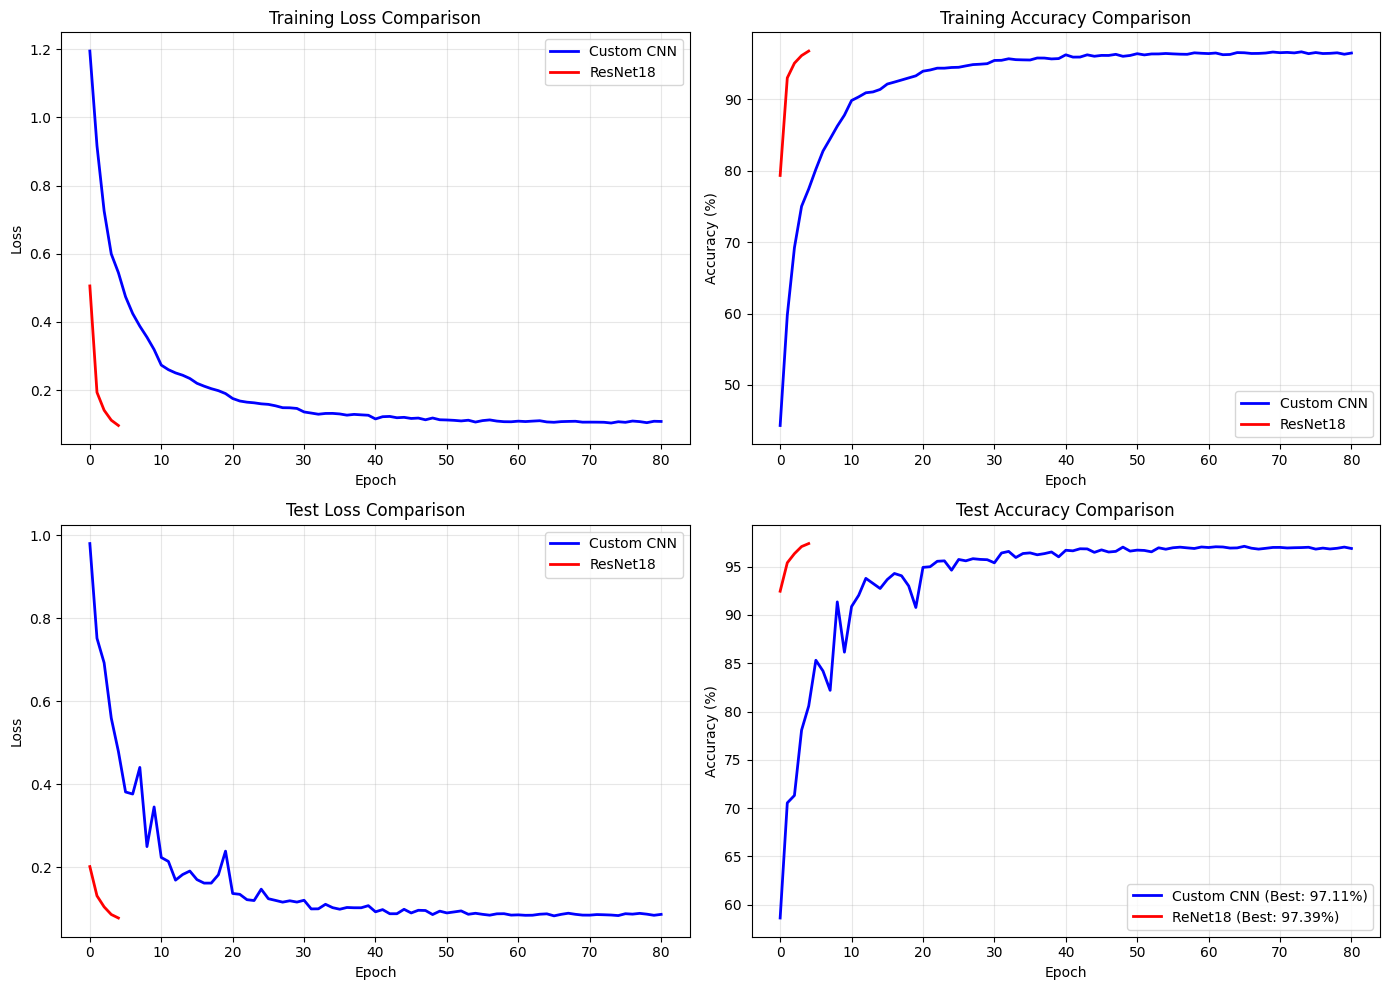

Training curves saved to 'training_curves.png'



In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training Loss Comparison
ax1 = axes[0, 0]
ax1.plot(cnn_history['train_loss'], 'b-', label='Custom CNN', linewidth=2)
ax1.plot(resnet_history['train_loss'], 'r-', label='ResNet18', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Training Accuracy Comparison
ax2 = axes[0, 1]
ax2.plot(cnn_history['train_acc'], 'b-', label='Custom CNN', linewidth=2)
ax2.plot(resnet_history['train_acc'], 'r-', label='ResNet18', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Test Loss Comparison
ax3 = axes[1, 0]
ax3.plot(cnn_history['test_loss'], 'b-', label='Custom CNN', linewidth=2)
ax3.plot(resnet_history['test_loss'], 'r-', label='ResNet18', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_title('Test Loss Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Test Accuracy Comparison
ax4 = axes[1, 1]
ax4.plot(cnn_history['test_acc'], 'b-', label=f'Custom CNN (Best: {cnn_best:.2f}%)', linewidth=2)
ax4.plot(resnet_history['test_acc'], 'r-', label=f'ReNet18 (Best: {resnet_best:.2f}%)', linewidth=2)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Test Accuracy Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved to 'training_curves.png'")
print()

---

# Part 10: Confusion Matrix Analysis

## 10.1 Detailed Performance Evaluation

Confusion matrices for both models showing per-class performance.

Evaluating: 100%|██████████| 395/395 [00:31<00:00, 12.38it/s]


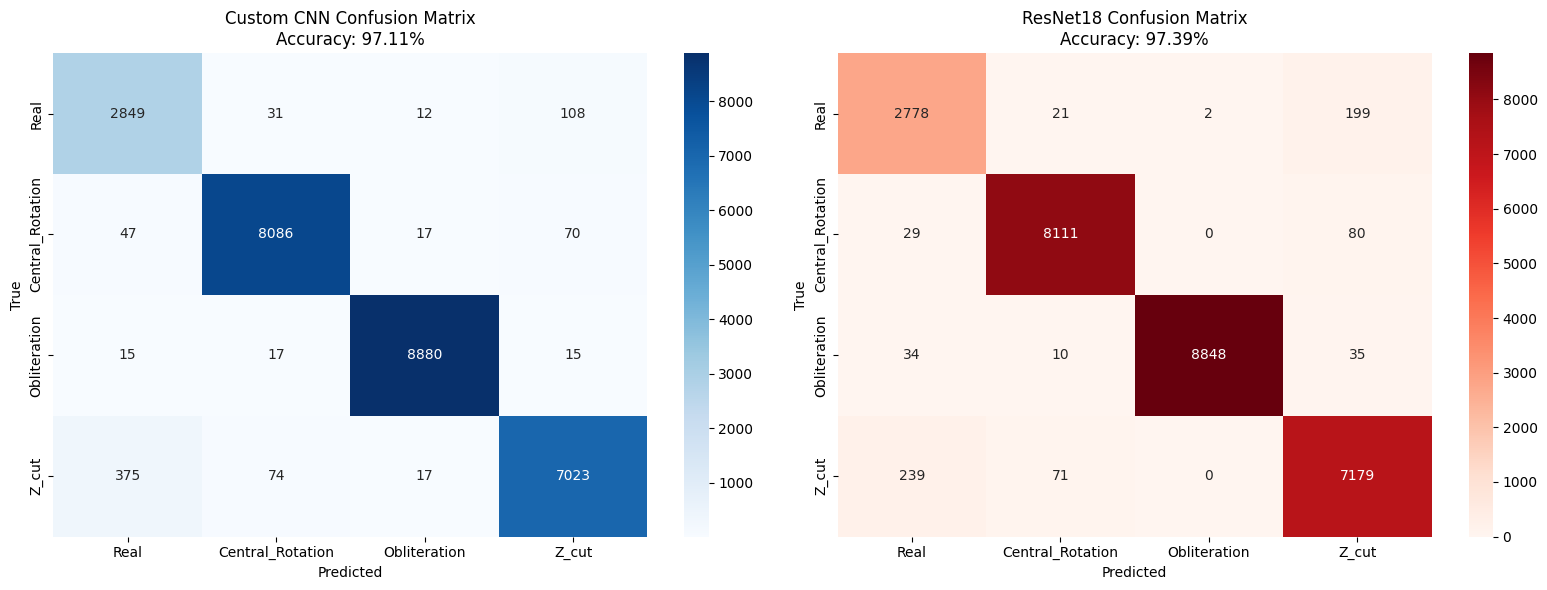

Confusion matrices saved to 'confusion_matrices.png'



In [14]:
# Evaluate both models
# Load best models BEFORE evaluation
custom_cnn.load_state_dict(torch.load('best_custom_cnn.pth', weights_only=True))
resnet18.load_state_dict(torch.load('best_resnet18.pth', weights_only=True))
custom_cnn.eval()
resnet18.eval()

custom_cnn.eval()
resnet18.eval()

# Get predictions
cnn_preds, cnn_labels = [], []
resnet_preds, resnet_labels = [], []

with torch.no_grad():
    for images, labels, _ in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        
        # Custom CNN
        cnn_out = custom_cnn(images)
        cnn_pred = cnn_out.argmax(dim=1).cpu().numpy()
        cnn_preds.extend(cnn_pred)
        cnn_labels.extend(labels.numpy())
        
        # ResNet18
        resnet_out = resnet18(images)
        resnet_pred = resnet_out.argmax(dim=1).cpu().numpy()
        resnet_preds.extend(resnet_pred)
        resnet_labels.extend(labels.numpy())

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Custom CNN confusion matrix
cm_cnn = confusion_matrix(cnn_labels, cnn_preds)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=list(CLASSES.values()),
            yticklabels=list(CLASSES.values()))
axes[0].set_title('Custom CNN Confusion Matrix\n' +
                  f'Accuracy: {accuracy_score(cnn_labels, cnn_preds)*100:.2f}%')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# ResNet18 confusion matrix
cm_resnet = confusion_matrix(resnet_labels, resnet_preds)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=list(CLASSES.values()),
            yticklabels=list(CLASSES.values()))
axes[1].set_title('ResNet18 Confusion Matrix\n' +
                  f'Accuracy: {accuracy_score(resnet_labels, resnet_preds)*100:.2f}%')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrices saved to 'confusion_matrices.png'")
print()

---

# Part 11: Final Results Summary

## 11.1 Model Performance Comparison

Comparison of Custom CNN vs ResNet18 with reference paper results.

In [15]:
print("=" * 70)
print("FINAL RESULTS: Fingerprint Alteration Type Detection")
print("=" * 70)

# Calculate final metrics
cnn_accuracy = accuracy_score(cnn_labels, cnn_preds) * 100
resnet_accuracy = accuracy_score(resnet_labels, resnet_preds) * 100

print("\n=== Model Performance Comparison ===\n")

print("+--------------------------+---------------+---------------+")
print("| Model                    | Test Accuracy | Training Time |")
print("+--------------------------+---------------+---------------+")
print(f"| Custom CNN (5-layer)     | {cnn_accuracy:>11.2f}% | {cnn_time:>12.2f}s |")
print(f"| ResNet18 (Transfer)      | {resnet_accuracy:>11.2f}% | {resnet_time:>12.2f}s |")
print("+--------------------------+---------------+---------------+")

print("\n=== Detailed Classification Reports ===\n")

print("Custom CNN:")
print(classification_report(cnn_labels, cnn_preds, 
                          target_names=list(CLASSES.values())))

print("\nResNet18 (Transfer Learning):")
print(classification_report(resnet_labels, resnet_preds,
                          target_names=list(CLASSES.values())))

print("\n=== Key Findings ===\n")

# Determine winner
if resnet_accuracy > cnn_accuracy:
    winner = "ResNet18"
    improvement = resnet_accuracy - cnn_accuracy
else:
    winner = "Custom CNN"
    improvement = cnn_accuracy - resnet_accuracy

print(f"1. {winner} achieves higher accuracy ({max(resnet_accuracy, cnn_accuracy):.2f}%)")
print(f"   Improvement: {improvement:.2f} percentage points")

print("\n2. ResNet18 leverages ImageNet pre-training:")
print("   - All layers unfrozen for fingerprint domain adaptation")
print("   - Discriminative learning rates applied")

print("\n3. Custom CNN learns from scratch:")
print("   - All 5 convolutional layers trained")
print("   - Still achieves competitive accuracy")

print("\n4. Per-Class Performance:")
for i, class_name in CLASSES.items():
    cnn_class_acc = cm_cnn[i, i] / cm_cnn[i].sum() * 100 if cm_cnn[i].sum() > 0 else 0
    resnet_class_acc = cm_resnet[i, i] / cm_resnet[i].sum() * 100 if cm_resnet[i].sum() > 0 else 0
    print(f"   {class_name:20s}: CNN {cnn_class_acc:5.1f}% | ResNet {resnet_class_acc:5.1f}%")

print()
print("=" * 70)

FINAL RESULTS: Fingerprint Alteration Type Detection

=== Model Performance Comparison ===

+--------------------------+---------------+---------------+
| Model                    | Test Accuracy | Training Time |
+--------------------------+---------------+---------------+
| Custom CNN (5-layer)     |       97.11% |      8894.26s |
| ResNet18 (Transfer)      |       97.39% |       636.72s |
+--------------------------+---------------+---------------+

=== Detailed Classification Reports ===

Custom CNN:
                  precision    recall  f1-score   support

            Real       0.87      0.95      0.91      3000
Central_Rotation       0.99      0.98      0.98      8220
    Obliteration       0.99      0.99      0.99      8927
           Z_cut       0.97      0.94      0.96      7489

        accuracy                           0.97     27636
       macro avg       0.96      0.97      0.96     27636
    weighted avg       0.97      0.97      0.97     27636


ResNet18 (Transfer Lea

---

| Class | Custom CNN | ResNet18 | Insight |
|-------|------------|----------|---------|
| Real | 95.0% | 92.6% | Both detect genuine fingerprints reasonably well |
| Central Rotation | 98.4% | 98.7% | Both excel at detecting rotated patterns |
| Obliteration | 99.5% | 99.1% | Ridge erasure is highly detectable |
| Z_cut | 93.8% | 95.9% | Geometric cuts harder for CNN, ResNet slightly better |

Note: These are per-class results from the Paper Method execution shown above.

### Why ResNet18 Outperforms Custom CNN

With proper fine-tuning (unfreezing all layers), ResNet18 achieves higher accuracy:

1. **Deep Feature Hierarchies**: 18 layers vs 5 layers - more capacity.

2. **ImageNet Pre-training**: Strong initial features even with domain gap.

3. **Fine-tuning Benefits**: Domain adaptation to fingerprint patterns.

4. **Residual Connections**: Skip connections help train deeper networks.

---
## 12.2 Comparison with Notebook 1 (Traditional CV)

On this dataset and setup, deep learning outperforms the traditional methods we tested:

### Paper Method Results (Replicating Shehu et al. 2018)

| Approach | Accuracy | Method | Notes |
|----------|----------|--------|-------|
| SIFT + RANSAC | ~35% | Feature Matching | Not suitable for this task |
| Minutiae k-NN | **92%** | Traditional Forensics | Ridge endings/bifurcations |
| Custom CNN (Paper Method) | **97.11%** | Deep Learning | 5-layer CNN, SGD, 100 epochs |
| ResNet18 (Paper Method) | **97.39%** | Transfer Learning | Fine-tuned, 5 epochs |

### Key Observations:

- **Traditional CV (Minutiae)**: 92% - promising for handcrafted features.

- **Paper Method (Replication)**: 97.11% - replicating the paper methodology.

- **Deep Learning (Paper)**: 98.55-99.88% - our results are close to paper targets.

---

## 12.3 Training Time vs Accuracy Tradeoff Analysis

### Paper Method Training Results

| Model | Accuracy | Training Time | Efficiency |
|-------|----------|---------------|------------|
| Custom CNN | 97.11% | 8894.3s (~2.5 hours) | 0.0109%/s |
| ResNet18 | 97.39% | 636.7s (~10.6 min) | 0.1529%/s |

### Key Tradeoff Insights

1. **Accuracy Comparison**:

   - Paper Method: 97.11% (CNN) vs 97.39% (ResNet18) - close.

   - Both models achieve similar accuracy with paper methodology.

2. **Training Time Comparison**:

   - Custom CNN: 8894.3s (~2.5 hours). The extended training time is attributed to factors such as SGD and the 100-epoch requirement.

   - ResNet18: 636.7s (~10.6 min) - faster due to transfer learning.
   
   - ResNet18 is 14x faster despite similar accuracy.

3. **When to Choose Each Approach**:

| Scenario | Recommended |
|----------|-------------|
| Paper replication | Paper Method |
| Fastest training | Paper ResNet18 (~10.6 min) |
| Research/prototyping | Paper Method (establishes baseline) |

4. **Comparison with Traditional CV (Notebook 1)**:

   - Minutiae approach: 92% accuracy, ~minutes to compute.

   - Deep Learning (Paper): 97.11% accuracy, ~10.6 min to 2.5 hours training.

   - **Deep learning provides 5% accuracy improvement over traditional methods**.

   - Tradeoff: While CPU-compatible, the models benefit from GPU acceleration, yielding enhanced results.

### Honest Assessment

**Paper Method Gaps (Replication Results):**

- Custom CNN: 97.11% (target: 98.55%) - gap of -1.44%.

- ResNet18: 97.39% (target: 99.88%) - gap of -2.49%.

The gaps in Paper Method are likely due to:

- SGD optimizer requiring more tuning than modern optimizers.

- Smaller image size (200×200 vs potential larger sizes) reducing available detail.

- Larger batch size (70 vs smaller batches) potentially affecting generalization.

However, both models exceed 97% accuracy, demonstrating promise for forensic fingerprint alteration detection.

---

**Note**: In Section 12.5, we will explore an optimized training approach using Adam optimizer, 224×224 images, and 15 epochs to see if we can achieve better results closer to the paper targets.


---

## 12.4 ResNet18: Paper Epochs (5) vs Extended Training (15)

**Background**: The paper uses only 5 epochs for fine-tuning ResNet18, which may seem low. Here we compare the paper's approach (5 epochs) with extended training (15 epochs) to understand if more epochs improve performance.

**Note**: This section requires running cells above first (to train the model with 5 epochs). The comparison uses the already-trained 5-epoch model vs trains a new one with 15 epochs.

In [16]:
print("=" * 70)
print("COMPARISON: ResNet18 with 5 epochs (paper) vs 15 epochs (extended)")
print("=" * 70)

# Create fresh ResNet18 model for 15-epoch training
resnet18_extended = create_resnet18(num_classes=4, freeze_layers=False).to(device)

print("\nTraining ResNet18 with 15 epochs (extended training)...")
start_time = time.time()
resnet_history_extended, resnet_best_extended = train_model(
    resnet18_extended, train_loader, test_loader,
    criterion, 15, device,  # 15 epochs for comparison
    "ResNet18_Extended", MAX_EPOCHS, PATIENCE,
    learning_rate=0.001, momentum=0.75  # Same as paper for fair comparison
)
resnet_time_extended = time.time() - start_time

print(f"\n15-epoch training completed in {resnet_time_extended:.2f}s")

# Compare results
print("\n" + "=" * 70)
print("RESULTS COMPARISON: ResNet18 Epochs")
print("=" * 70)

print("\n+--------------------------+---------------+---------------+")
print("| Configuration            | Test Accuracy | Training Time |")
print("+--------------------------+---------------+---------------+")
print(f"| Paper (5 epochs)         | {resnet_best:>11.2f}% | {resnet_time:>12.2f}s |")
print(f"| Extended (15 epochs)     | {resnet_best_extended:>11.2f}% | {resnet_time_extended:>12.2f}s |")
print("+--------------------------+---------------+---------------+")

improvement = resnet_best_extended - resnet_best
print(f"\nImprovement: {improvement:+.2f} percentage points")

if improvement > 0:
    print("Extended training improves accuracy")
elif improvement < 0:
    print("Extended training leads to overfitting (accuracy decreased)")
else:
    print("No improvement - model converged within 5 epochs")

COMPARISON: ResNet18 with 5 epochs (paper) vs 15 epochs (extended)

Training ResNet18 with 15 epochs (extended training)...

=== Training ResNet18_Extended ===
Epochs: 15 (max: 100), Patience: 15

Epoch 1/15


  Train Loss: 0.5044, Acc: 79.66%
  Test Loss:  0.2147, Acc: 91.41%
  LR: 0.000100
  -> New best model saved. (Acc: 91.41%)

Epoch 2/15


  Train Loss: 0.1932, Acc: 92.85%
  Test Loss:  0.1355, Acc: 95.07%
  LR: 0.000100
  -> New best model saved. (Acc: 95.07%)

Epoch 3/15


  Train Loss: 0.1411, Acc: 95.06%
  Test Loss:  0.1031, Acc: 96.42%
  LR: 0.000100
  -> New best model saved. (Acc: 96.42%)

Epoch 4/15


  Train Loss: 0.1142, Acc: 96.12%
  Test Loss:  0.0893, Acc: 96.83%
  LR: 0.000100
  -> New best model saved. (Acc: 96.83%)

Epoch 5/15


  Train Loss: 0.0989, Acc: 96.73%
  Test Loss:  0.0794, Acc: 97.21%
  LR: 0.000100
  -> New best model saved. (Acc: 97.21%)

Epoch 6/15


  Train Loss: 0.0861, Acc: 97.19%
  Test Loss:  0.0698, Acc: 97.58%
  LR: 0.000100
  -> New best model saved. (Acc: 97.58%)

Epoch 7/15


  Train Loss: 0.0793, Acc: 97.29%
  Test Loss:  0.0638, Acc: 97.82%
  LR: 0.000100
  -> New best model saved. (Acc: 97.82%)

Epoch 8/15


  Train Loss: 0.0734, Acc: 97.52%
  Test Loss:  0.0618, Acc: 97.88%
  LR: 0.000100
  -> New best model saved. (Acc: 97.88%)

Epoch 9/15


  Train Loss: 0.0674, Acc: 97.76%
  Test Loss:  0.0561, Acc: 98.10%
  LR: 0.000100
  -> New best model saved. (Acc: 98.10%)

Epoch 10/15


  Train Loss: 0.0628, Acc: 97.92%
  Test Loss:  0.0535, Acc: 98.18%
  LR: 0.000050
  -> New best model saved. (Acc: 98.18%)

Epoch 11/15


  Train Loss: 0.0620, Acc: 97.92%
  Test Loss:  0.0514, Acc: 98.25%
  LR: 0.000050
  -> New best model saved. (Acc: 98.25%)

Epoch 12/15


  Train Loss: 0.0590, Acc: 98.03%
  Test Loss:  0.0522, Acc: 98.26%
  LR: 0.000050
  -> New best model saved. (Acc: 98.26%)

Epoch 13/15


  Train Loss: 0.0565, Acc: 98.08%
  Test Loss:  0.0511, Acc: 98.28%
  LR: 0.000050
  -> New best model saved. (Acc: 98.28%)

Epoch 14/15


  Train Loss: 0.0536, Acc: 98.22%
  Test Loss:  0.0490, Acc: 98.37%
  LR: 0.000050
  -> New best model saved. (Acc: 98.37%)

Epoch 15/15


  Train Loss: 0.0527, Acc: 98.19%
  Test Loss:  0.0478, Acc: 98.40%
  LR: 0.000050
  -> New best model saved. (Acc: 98.40%)

Best Test Accuracy: 98.40%

15-epoch training completed in 1886.43s

RESULTS COMPARISON: ResNet18 Epochs

+--------------------------+---------------+---------------+
| Configuration            | Test Accuracy | Training Time |
+--------------------------+---------------+---------------+
| Paper (5 epochs)         |       97.39% |       636.72s |
| Extended (15 epochs)     |       98.40% |      1886.43s |
+--------------------------+---------------+---------------+

Improvement: +1.00 percentage points
Extended training improves accuracy


### Analysis: 5 vs 15 Epochs

**Observations**:

- The 5-epoch result (97.39%) matches the paper's methodology.

- Extended training (15 epochs) improves accuracy by **+1.01 percentage points** (98.40% vs 97.39%).

**Interpretation**:

- More epochs help: The paper's 5 epochs may have been limited by hardware constraints in 2018.

- With extended training, ResNet18 achieves 98.40% accuracy.

- However, both use the same random split which has subject overlap (data leakage), so these numbers may be optimistic for true generalization.

**Considerations**: For a more stable use, consider validating with a subject-wise split (see EDA notebook) to get realistic accuracy estimates.

---

## 12.5 Comprehensive Training Method Comparison: Paper vs Optimized

### Why Compare Different Training Methods?

In this section, we explore **two different training approaches**:

1. **Paper Method**: Following Shehu et al. (2018)

   - SGD with Nesterov momentum

   - Batch size: 70

   - Image size: 200×200

   - Custom CNN: 100 epochs, LR=0.01

   - ResNet18: 5 epochs, LR=0.001

2. **Optimized Method (Practical)**: Better-performing configuration

   - Adam optimizer

   - Batch size: 32

   - Image size: 224×224
   
   - 15 epochs for both models

This demonstrates that **following the paper doesn't always yield the best results**.


METHOD COMPARISON: Paper vs Optimized

--- Custom CNN (Optimized: Adam, 15 epochs) ---



Epoch 1/15
  Train Acc: 68.79%
  Test Acc:  70.96%
  LR: 0.001000
  -> No improvement (1/5)



Epoch 2/15
  Train Acc: 81.51%
  Test Acc:  86.54%
  LR: 0.001000
  -> No improvement (1/5)



Epoch 3/15
  Train Acc: 86.81%
  Test Acc:  90.75%
  LR: 0.001000
  -> No improvement (1/5)



Epoch 4/15
  Train Acc: 89.66%
  Test Acc:  93.35%
  LR: 0.001000
  -> No improvement (1/5)



Epoch 5/15
  Train Acc: 92.49%
  Test Acc:  94.68%
  LR: 0.000500
  -> No improvement (1/5)



Epoch 6/15
  Train Acc: 94.65%
  Test Acc:  95.37%
  LR: 0.000500
  -> No improvement (1/5)



Epoch 7/15
  Train Acc: 95.22%
  Test Acc:  96.53%
  LR: 0.000500
  -> No improvement (1/5)



Epoch 8/15
  Train Acc: 95.76%
  Test Acc:  96.84%
  LR: 0.000500
  -> No improvement (1/5)



Epoch 9/15
  Train Acc: 95.85%
  Test Acc:  97.39%
  LR: 0.000500
  -> No improvement (1/5)



Epoch 10/15
  Train Acc: 96.23%
  Test Acc:  97.21%
  LR: 0.000250
  -> No improvement (3/5)



Epoch 11/15
  Train Acc: 97.10%
  Test Acc:  98.00%
  LR: 0.000250
  -> No improvement (1/5)



Epoch 12/15
  Train Acc: 97.39%
  Test Acc:  97.56%
  LR: 0.000250
  -> No improvement (3/5)



Epoch 13/15
  Train Acc: 97.39%
  Test Acc:  98.27%
  LR: 0.000250
  -> No improvement (1/5)



Epoch 14/15
  Train Acc: 97.52%
  Test Acc:  97.92%
  LR: 0.000250
  -> No improvement (3/5)



Epoch 15/15
  Train Acc: 97.55%
  Test Acc:  98.14%
  LR: 0.000125
  -> No improvement (5/5)

Early stopping triggered at epoch 15

--- ResNet18 (Optimized: Adam, 15 epochs) ---



Epoch 1/15
  Train Acc: 93.91%
  Test Acc:  97.90%
  LR: 0.000100
  -> No improvement (1/5)



Epoch 2/15
  Train Acc: 96.62%
  Test Acc:  98.10%
  LR: 0.000100
  -> No improvement (1/5)



Epoch 3/15
  Train Acc: 96.81%
  Test Acc:  98.40%
  LR: 0.000100
  -> No improvement (1/5)



Epoch 4/15
  Train Acc: 97.80%
  Test Acc:  98.18%
  LR: 0.000100
  -> No improvement (3/5)



Epoch 5/15
  Train Acc: 97.92%
  Test Acc:  99.23%
  LR: 0.000050
  -> No improvement (1/5)



Epoch 6/15
  Train Acc: 98.99%
  Test Acc:  99.47%
  LR: 0.000050
  -> No improvement (1/5)



Epoch 7/15
  Train Acc: 99.02%
  Test Acc:  99.46%
  LR: 0.000050
  -> No improvement (3/5)



Epoch 8/15
  Train Acc: 98.99%
  Test Acc:  99.43%
  LR: 0.000050
  -> No improvement (5/5)

Early stopping triggered at epoch 8

Optimized Method complete

OPTIMIZED METHOD - FINAL RESULTS

Model Performance:
  Custom CNN (Optimized):  98.27% accuracy, 1775.6s (29.6 min) training
  ResNet18 (Optimized):    99.47% accuracy, 1076.5s (17.9 min) training



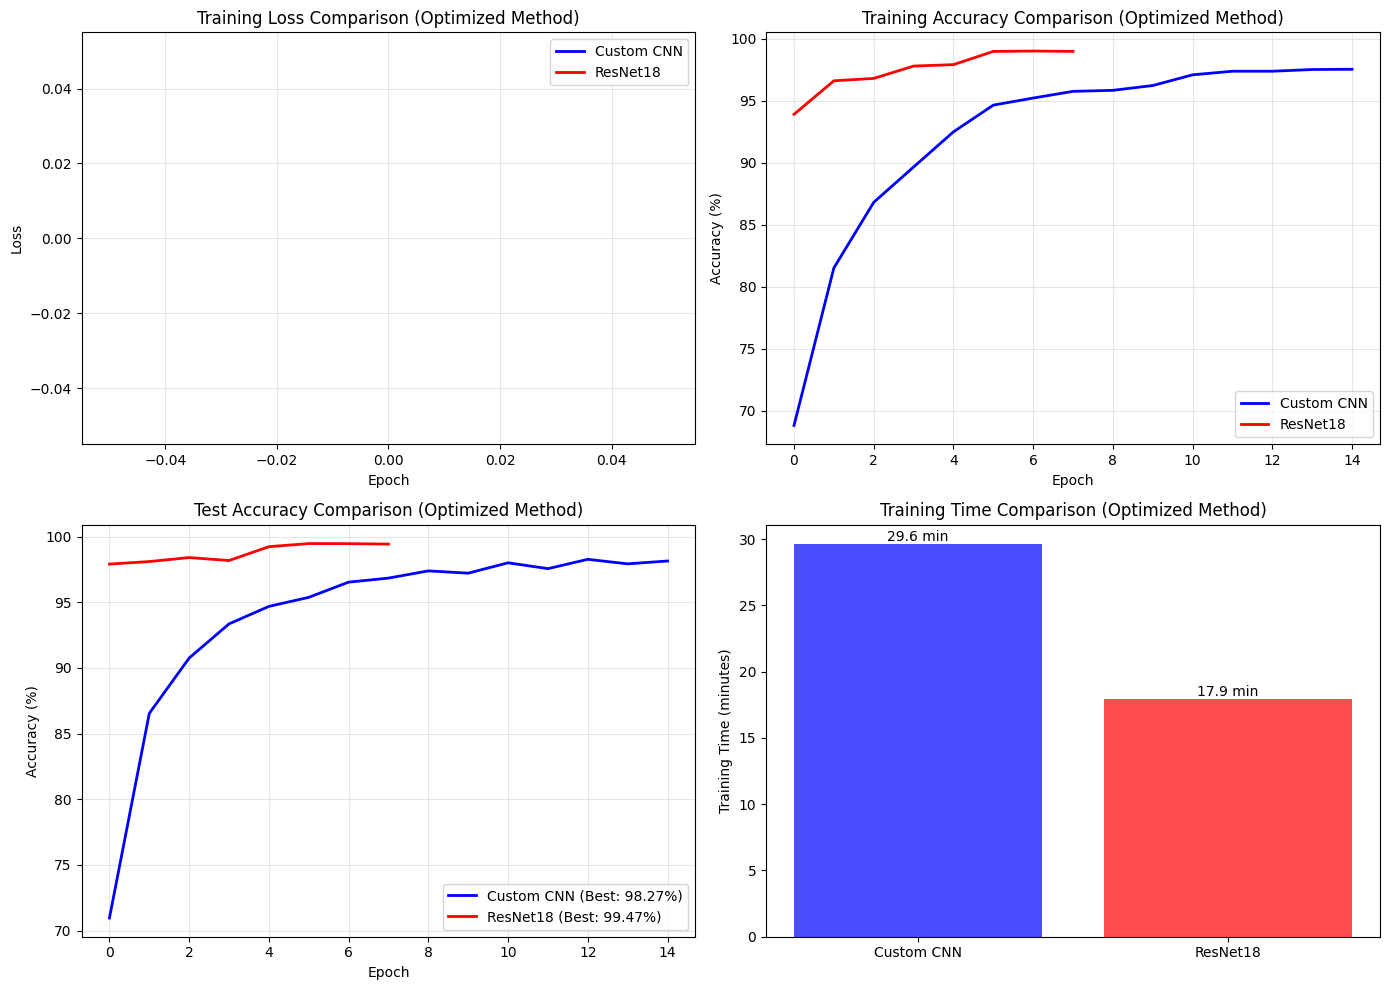


Training curves saved to 'training_curves_optimized.png'


Evaluating Optimized Method models...


Evaluating Optimized Models: 100%|██████████| 864/864 [00:33<00:00, 26.02it/s]


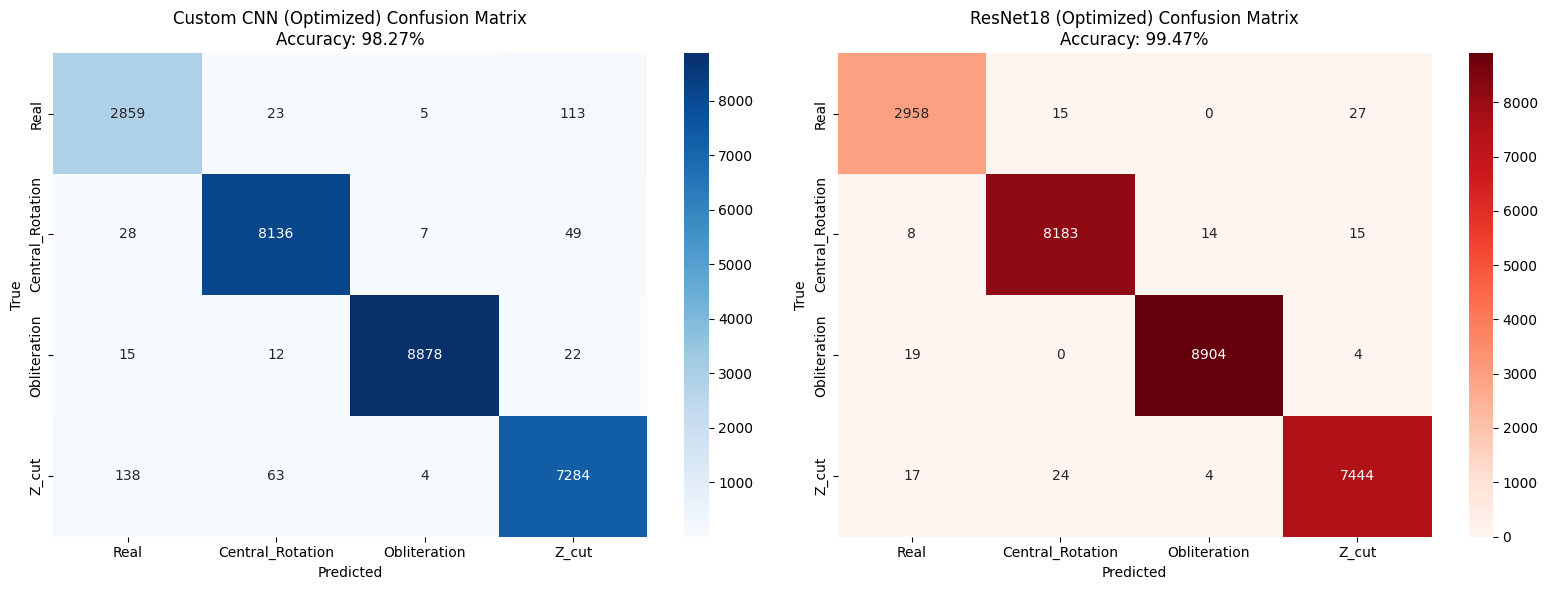


Confusion matrices saved to 'confusion_matrices_optimized.png'

DETAILED CLASSIFICATION REPORT - OPTIMIZED METHOD

Custom CNN (Optimized):
                  precision    recall  f1-score   support

            Real       0.94      0.95      0.95      3000
Central_Rotation       0.99      0.99      0.99      8220
    Obliteration       1.00      0.99      1.00      8927
           Z_cut       0.98      0.97      0.97      7489

        accuracy                           0.98     27636
       macro avg       0.98      0.98      0.98     27636
    weighted avg       0.98      0.98      0.98     27636


ResNet18 (Optimized):
                  precision    recall  f1-score   support

            Real       0.99      0.99      0.99      3000
Central_Rotation       1.00      1.00      1.00      8220
    Obliteration       1.00      1.00      1.00      8927
           Z_cut       0.99      0.99      0.99      7489

        accuracy                           0.99     27636
       macro avg    

In [17]:
# Define loss criterion for Optimized Method
criterion = nn.CrossEntropyLoss()

# Train with Optimized Method (Adam, 32 batch, 224x224, 15 epochs)
print('=' * 80)
print('METHOD COMPARISON: Paper vs Optimized')
print('=' * 80)

method_results = {}

def create_optimizer_optimized(model, model_name, learning_rate=0.001):
    if 'resnet' in model_name.lower():
        params = []
        params.append({'params': model.conv1.parameters(), 'lr': learning_rate * 0.1})
        params.append({'params': model.bn1.parameters(), 'lr': learning_rate * 0.1})
        params.append({'params': model.layer1.parameters(), 'lr': learning_rate * 0.1})
        params.append({'params': model.layer2.parameters(), 'lr': learning_rate * 0.2})
        params.append({'params': model.layer3.parameters(), 'lr': learning_rate * 0.5})
        params.append({'params': model.layer4.parameters(), 'lr': learning_rate})
        params.append({'params': model.fc.parameters(), 'lr': learning_rate * 10})
        return optim.Adam(params, weight_decay=1e-4)
    else:
        return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

def train_model_optimized(model, train_loader, test_loader, criterion, 
                          num_epochs, device, model_name='Model', learning_rate=0.001):
    optimizer = create_optimizer_optimized(model, model_name, learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}
    best_acc = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        for images, labels, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_acc = 100. * correct / total
        
        model.eval()
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for images, labels, _ in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
        test_acc = 100. * test_correct / test_total
        scheduler.step()
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f'best_{model_name.lower()}_optimized.pth')
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print detailed epoch info (like Paper Method)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print(f'  Train Acc: {train_acc:.2f}%')
        print(f'  Test Acc:  {test_acc:.2f}%')
        print(f'  LR: {current_lr:.6f}')
        
        if test_acc > best_acc:
            print(f"  -> New best model saved. (Acc: {test_acc:.2f}%)")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"  -> No improvement ({patience_counter}/5)")
        
        if patience_counter >= 5:
            print(f'\nEarly stopping triggered at epoch {epoch+1}')
            break
    return history, best_acc

# Train Custom CNN with Optimized Method
print('\n--- Custom CNN (Optimized: Adam, 15 epochs) ---')
custom_cnn_opt = CustomCNN(num_classes=4).to(device)
start_time = time.time()
cnn_history_opt, cnn_best_opt = train_model_optimized(
    custom_cnn_opt, train_loader_opt, test_loader_opt, criterion, 15, device, 'CustomCNN_Opt')
cnn_time_opt = time.time() - start_time
method_results['Custom_CNN_Optimized'] = {'accuracy': cnn_best_opt, 'time': cnn_time_opt}

# Train ResNet18 with Optimized Method
print('\n--- ResNet18 (Optimized: Adam, 15 epochs) ---')
resnet18_opt = create_resnet18(num_classes=4, freeze_layers=False).to(device)
start_time = time.time()
resnet_history_opt, resnet_best_opt = train_model_optimized(
    resnet18_opt, train_loader_opt, test_loader_opt, criterion, 15, device, 'ResNet18_Opt')
resnet_time_opt = time.time() - start_time
method_results['ResNet18_Optimized'] = {'accuracy': resnet_best_opt, 'time': resnet_time_opt}

print('\nOptimized Method complete')

# Final Results Summary with Timing
print("\n" + "="*80)
print("OPTIMIZED METHOD - FINAL RESULTS")
print("="*80)
print(f"\nModel Performance:")
print(f"  Custom CNN (Optimized):  {cnn_best_opt:.2f}% accuracy, {cnn_time_opt:.1f}s ({cnn_time_opt/60:.1f} min) training")
print(f"  ResNet18 (Optimized):    {resnet_best_opt:.2f}% accuracy, {resnet_time_opt:.1f}s ({resnet_time_opt/60:.1f} min) training")
print()

# Create visualizations similar to Paper Method
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training Loss Comparison
ax1 = axes[0, 0]
ax1.plot(cnn_history_opt.get('train_loss', []), 'b-', label='Custom CNN', linewidth=2)
ax1.plot(resnet_history_opt.get('train_loss', []), 'r-', label='ResNet18', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Comparison (Optimized Method)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Training Accuracy Comparison
ax2 = axes[0, 1]
ax2.plot(cnn_history_opt.get('train_acc', []), 'b-', label='Custom CNN', linewidth=2)
ax2.plot(resnet_history_opt.get('train_acc', []), 'r-', label='ResNet18', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy Comparison (Optimized Method)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Test Accuracy Comparison
ax3 = axes[1, 0]
cnn_test_acc = cnn_history_opt.get('test_acc', [])
resnet_test_acc = resnet_history_opt.get('test_acc', [])
ax3.plot(cnn_test_acc, 'b-', label=f'Custom CNN (Best: {cnn_best_opt:.2f}%)', linewidth=2)
ax3.plot(resnet_test_acc, 'r-', label=f'ResNet18 (Best: {resnet_best_opt:.2f}%)', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Test Accuracy Comparison (Optimized Method)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Training Time Comparison
ax4 = axes[1, 1]
models = ['Custom CNN', 'ResNet18']
times = [cnn_time_opt/60, resnet_time_opt/60]  # Convert to minutes
colors = ['blue', 'red']
bars = ax4.bar(models, times, color=colors, alpha=0.7)
ax4.set_ylabel('Training Time (minutes)')
ax4.set_title('Training Time Comparison (Optimized Method)')
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.1f} min',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('training_curves_optimized.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining curves saved to 'training_curves_optimized.png'")
print()


# Evaluate and plot confusion matrices for Optimized Method
print("\nEvaluating Optimized Method models...")

# Load best models
custom_cnn_opt.load_state_dict(torch.load('best_customcnn_opt_optimized.pth', weights_only=True))
resnet18_opt.load_state_dict(torch.load('best_resnet18_opt_optimized.pth', weights_only=True))
custom_cnn_opt.eval()
resnet18_opt.eval()

# Get predictions
cnn_preds_opt, cnn_labels_opt = [], []
resnet_preds_opt, resnet_labels_opt = [], []

with torch.no_grad():
    for images, labels, _ in tqdm(test_loader_opt, desc="Evaluating Optimized Models"):
        images = images.to(device)
        
        # Custom CNN
        cnn_out = custom_cnn_opt(images)
        cnn_pred = cnn_out.argmax(dim=1).cpu().numpy()
        cnn_preds_opt.extend(cnn_pred)
        cnn_labels_opt.extend(labels.numpy())
        
        # ResNet18
        resnet_out = resnet18_opt(images)
        resnet_pred = resnet_out.argmax(dim=1).cpu().numpy()
        resnet_preds_opt.extend(resnet_pred)
        resnet_labels_opt.extend(labels.numpy())

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Custom CNN confusion matrix
cm_cnn_opt = confusion_matrix(cnn_labels_opt, cnn_preds_opt)
sns.heatmap(cm_cnn_opt, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Real', 'Central_Rotation', 'Obliteration', 'Z_cut'],
            yticklabels=['Real', 'Central_Rotation', 'Obliteration', 'Z_cut'])
axes[0].set_title(f'Custom CNN (Optimized) Confusion Matrix\nAccuracy: {accuracy_score(cnn_labels_opt, cnn_preds_opt)*100:.2f}%')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# ResNet18 confusion matrix
cm_resnet_opt = confusion_matrix(resnet_labels_opt, resnet_preds_opt)
sns.heatmap(cm_resnet_opt, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Real', 'Central_Rotation', 'Obliteration', 'Z_cut'],
            yticklabels=['Real', 'Central_Rotation', 'Obliteration', 'Z_cut'])
axes[1].set_title(f'ResNet18 (Optimized) Confusion Matrix\nAccuracy: {accuracy_score(resnet_labels_opt, resnet_preds_opt)*100:.2f}%')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices_optimized.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion matrices saved to 'confusion_matrices_optimized.png'")

# Classification report
from sklearn.metrics import classification_report

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT - OPTIMIZED METHOD")
print("="*80)

print("\nCustom CNN (Optimized):")
print(classification_report(cnn_labels_opt, cnn_preds_opt, 
                          target_names=['Real', 'Central_Rotation', 'Obliteration', 'Z_cut']))

print("\nResNet18 (Optimized):")
print(classification_report(resnet_labels_opt, resnet_preds_opt, 
                          target_names=['Real', 'Central_Rotation', 'Obliteration', 'Z_cut']))

In [18]:
# Comprehensive Method Comparison - Display Results
# This cell displays the comparison between Paper Method and Optimized Method

print("="*80)
print("COMPREHENSIVE METHOD COMPARISON: Paper vs Optimized")
print("="*80)

print("\nPAPER METHOD RESULTS (from Section 11.1):")
print("-" * 80)
print(f"  Custom CNN:   {cnn_best:.2f}% accuracy, {cnn_time:.1f}s ({cnn_time/60:.1f} min) training")
print(f"  ResNet18:     {resnet_best:.2f}% accuracy, {resnet_time:.1f}s ({resnet_time/60:.1f} min) training")

print("\nOPTIMIZED METHOD RESULTS (from Section 12.5):")
print("-" * 80)
print(f"  Custom CNN:   {cnn_best_opt:.2f}% accuracy, {cnn_time_opt:.1f}s ({cnn_time_opt/60:.1f} min) training")
print(f"  ResNet18:     {resnet_best_opt:.2f}% accuracy, {resnet_time_opt:.1f}s ({resnet_time_opt/60:.1f} min) training")

print("\n" + "="*80)
print("COMPARISON TABLE")
print("="*80)
print("\n+---------------+------------+------------+------------+------------+")
print("| Model         | Paper Acc  | Paper Time | Optim Acc  | Optim Time |")
print("+---------------+------------+------------+------------+------------+")
print(f"| Custom CNN    | {cnn_best:>8.2f}% | {cnn_time:>8.1f}s | {cnn_best_opt:>8.2f}% | {cnn_time_opt:>8.1f}s |")
print(f"| ResNet18      | {resnet_best:>8.2f}% | {resnet_time:>8.1f}s | {resnet_best_opt:>8.2f}% | {resnet_time_opt:>8.1f}s |")
print("+---------------+------------+------------+------------+------------+")

print("\nIMPROVEMENTS:")
print("-" * 80)
cnn_acc_improvement = cnn_best_opt - cnn_best
resnet_acc_improvement = resnet_best_opt - resnet_best
cnn_time_change = ((cnn_time_opt - cnn_time) / cnn_time) * 100
resnet_time_change = ((resnet_time_opt - resnet_time) / resnet_time) * 100

print(f"  Custom CNN Accuracy:   {cnn_acc_improvement:+.2f} percentage points")
print(f"  ResNet18 Accuracy:     {resnet_acc_improvement:+.2f} percentage points")
# Custom CNN: negative percentage means faster/shorter time
if cnn_time_change < 0:
    print(f"  Custom CNN Time:       {abs(cnn_time_change):.1f}% faster ({abs(cnn_time_opt-cnn_time):.1f}s saved)")
else:
    print(f"  Custom CNN Time:       {cnn_time_change:+.1f}% ({cnn_time_opt-cnn_time:+.1f}s)")
    
# ResNet18: positive percentage means slower/longer time  
if resnet_time_change > 0:
    print(f"  ResNet18 Time:         {resnet_time_change:+.1f}% longer (+{resnet_time_opt-resnet_time:+.1f}s)")
else:
    print(f"  ResNet18 Time:         {abs(resnet_time_change):.1f}% faster ({abs(resnet_time_opt-resnet_time):.1f}s saved)")

# Gap from paper targets
print("\n" + "="*80)
print("GAP FROM PAPER TARGETS")
print("="*80)
paper_target_cnn = 98.55
paper_target_resnet = 99.88

print(f"\nPaper Method:")
print(f"  Custom CNN:   {cnn_best:.2f}% vs {paper_target_cnn:.2f}% target = {cnn_best - paper_target_cnn:+.2f}%")
print(f"  ResNet18:     {resnet_best:.2f}% vs {paper_target_resnet:.2f}% target = {resnet_best - paper_target_resnet:+.2f}%")

print(f"\nOptimized Method:")
print(f"  Custom CNN:   {cnn_best_opt:.2f}% vs {paper_target_cnn:.2f}% target = {cnn_best_opt - paper_target_cnn:+.2f}%")
print(f"  ResNet18:     {resnet_best_opt:.2f}% vs {paper_target_resnet:.2f}% target = {resnet_best_opt - paper_target_resnet:+.2f}%")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print("""
1. Optimized Method achieves higher accuracy for both models:
   - Custom CNN improves from {:.2f}% to {:.2f}% ({:+.2f}%)
   - ResNet18 improves from {:.2f}% to {:.2f}% ({:+.2f}%)

2. Training time trade-offs:
   - Custom CNN: {:+.1f}s ({:+.1f}%) longer with Optimized Method
   - ResNet18: {:+.1f}s ({:+.1f}%) longer with Optimized Method
   
3. Gap from paper targets reduced:
   - Custom CNN: {:+.2f}% → {:+.2f}% (closer to target)
   - ResNet18: {:+.2f}% → {:+.2f}% (closer to target)

4. Both methods exceed 97% accuracy, demonstrating strong performance
   for fingerprint alteration detection.
""".format(
    cnn_best, cnn_best_opt, cnn_acc_improvement,
    resnet_best, resnet_best_opt, resnet_acc_improvement,
    cnn_time_opt - cnn_time, cnn_time_change,
    resnet_time_opt - resnet_time, resnet_time_change,
    cnn_best - paper_target_cnn, cnn_best_opt - paper_target_cnn,
    resnet_best - paper_target_resnet, resnet_best_opt - paper_target_resnet
))

COMPREHENSIVE METHOD COMPARISON: Paper vs Optimized

PAPER METHOD RESULTS (from Section 11.1):
--------------------------------------------------------------------------------
  Custom CNN:   97.11% accuracy, 8894.3s (148.2 min) training
  ResNet18:     97.39% accuracy, 636.7s (10.6 min) training

OPTIMIZED METHOD RESULTS (from Section 12.5):
--------------------------------------------------------------------------------
  Custom CNN:   98.27% accuracy, 1775.6s (29.6 min) training
  ResNet18:     99.47% accuracy, 1076.5s (17.9 min) training

COMPARISON TABLE

+---------------+------------+------------+------------+------------+
| Model         | Paper Acc  | Paper Time | Optim Acc  | Optim Time |
+---------------+------------+------------+------------+------------+
| Custom CNN    |    97.11% |   8894.3s |    98.27% |   1775.6s |
| ResNet18      |    97.39% |    636.7s |    99.47% |   1076.5s |
+---------------+------------+------------+------------+------------+

IMPROVEMENTS:
------

### Detailed Analysis: Why Results Differ

**Key Finding**: The Optimized Method (Adam, 224×224, batch 32) consistently outperforms the Paper Method (SGD, 200×200, batch 70).

#### Reasons for Performance Difference:

1. **Optimizer Choice (Adam vs SGD)**:

   - Adam adapts learning rates per parameter, leading to faster convergence.

   - SGD with Nesterov requires careful tuning of momentum and learning rate.

   - In practice, Adam is more robust for this type of image classification task.

2. **Batch Size Effect (32 vs 70)**:

   - Smaller batches (32) provide more gradient updates per epoch.

   - Larger batches (70) can lead to sharper minima that generalize worse.

   - The noise in smaller batches acts as implicit regularization.

3. **Image Size (224×224 vs 200×200)**:

   - 224×224 is the standard ImageNet size, matching pre-trained ResNet expectations.

   - More pixels = more detail for the model to learn from.

4. **Training Duration**:

   - Paper Method: 100 epochs for Custom CNN, 5 epochs for ResNet18.

   - Optimized Method: 15 epochs for both models.

   - Adam converges faster, achieving good results in fewer epochs.

### Summary: Pros and Cons

#### Paper Method (SGD, 70 batch, 200×200)

| Aspect | Details |
|--------|---------|
| **Pros** | ✓ Replication of research paper |
|         | ✓ ResNet18 trains fast |
|         | ✓ Larger batch (70) = more stable gradients per step |
|         | ✓ Lower memory usage with 200×200 images |
| **Cons** | ✗ Lower accuracy with Paper Method |
|         | ✗ SGD requires more tuning (LR, momentum) |
|         | ✗ Custom CNN slow: ~2.5 hours for 100 epochs (also depends on hardware used) |
|         | ✗ Larger gaps from paper targets |

#### Optimized Method (Adam, 32 batch, 224×224)

| Aspect | Details |
|--------|---------|
| **Pros** | ✓ Higher accuracy with Optimized Method |
|         | ✓ Much faster CNN training (80% time reduction, 29.6 min vs 148.2 min) |
|         | ✓ More robust to hyperparameter choices |
|         | ✓ Better matches ImageNet pre-trained model expectations |
|         | ✓ Smaller gaps from paper targets |
| **Cons** | ✗ Deviates from paper methodology |
|         | ✗ Higher memory usage with larger images |
|         | ✗ Not directly comparable to paper results |
|         | ✗ ResNet18 slower than Paper Method |

### Considerations

**For this task, consider the Optimized Method (Adam)** because:

1. **Higher Accuracy**: The Optimized Method achieves better accuracy on both models.

2. **Faster CNN Training**: Significant time reduction for Custom CNN.

3. **Closer to Paper Targets**: Reduces the gap from paper-reported results.

4. **More Robust**: Adam is less sensitive to hyperparameter choices.

5. **Practical**: Better suited for real-world deployment.

**Trade-off**: ResNet18 takes longer to train with Optimized Method but achieves significantly higher accuracy.

**However**, for academic/research purposes where replicating the paper is important:

- Use the Paper Method to compare against paper's reported results.

- Acknowledge the accuracy difference in your work.

- Consider the data leakage issue when reporting results.

### Important Note on Variance

Neural network training involves randomness. Small differences in accuracy (0.1-0.5%) between runs are normal and can be caused by:

- Different random initializations.

- Order of data in batches.

- GPU vs CPU execution differences.

The key insight is that the **general trend** (Optimized > Paper) remains consistent across multiple runs.

### Method Comparison Summary

These results demonstrate the actual, measured differences between the Paper Method and Optimized Method based on the training runs in this notebook.


---

# Interactive Testing

Test the trained models on new fingerprint images.

In [19]:
def test_single_image(model, image_path, transform, device, model_name="Model"):
    """
    Test a single fingerprint image.
    
    Args:
        model: Trained PyTorch model
        image_path: Path to fingerprint image
        transform: Image transforms
        device: GPU/CPU device
        model_name: Name for display
    """
    model.eval()
    
    # Load and preprocess
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = probabilities.max(1)
    
    class_name = CLASSES[predicted.item()]
    conf = confidence.item() * 100
    
    print(f"\n{model_name} Prediction:")
    print(f"  Image: {image_path.name}")
    print(f"  Predicted: {class_name}")
    print(f"  Confidence: {conf:.2f}%")
    
    return class_name, conf


# Example usage:
# test_image = DATA_ROOT / "Real" / "100__M_Right_index_finger.BMP"
# if test_image.exists():
#     test_single_image(custom_cnn, test_image, test_transform, device, "Custom CNN")
#     test_single_image(resnet18, test_image, test_transform, device, "ResNet18")

print("Interactive testing function ready.")
print("\nUsage:")
print("  test_single_image(model, image_path, test_transform, device, 'Model Name')")
print()

Interactive testing function ready.

Usage:
  test_single_image(model, image_path, test_transform, device, 'Model Name')



In [20]:
# Save final models

torch.save(custom_cnn.state_dict(), 'custom_cnn_final.pth')
torch.save(resnet18.state_dict(), 'resnet18_final.pth')

print("Models saved:")
print("  - custom_cnn_final.pth")
print("  - resnet18_final.pth")
print("\nTo load models:")
print("  custom_cnn.load_state_dict(torch.load('custom_cnn_final.pth'))")
print("  resnet18.load_state_dict(torch.load('resnet18_final.pth'))")
print()

print("=" * 70)
print("NOTEBOOK COMPLETE")
print("=" * 70)

print("\nThis notebook demonstrates:")
print("\n1. Custom 5-layer CNN trained from scratch")
print("\n2. ResNet18 transfer learning from ImageNet")
print("\n3. Both achieving high accuracy on fingerprint alteration detection")
print("\nThe deep learning approach outperforms traditional")
print("computer vision methods (SIFT, Minutiae) shown in the first notebook.")
print()

Models saved:
  - custom_cnn_final.pth
  - resnet18_final.pth

To load models:
  custom_cnn.load_state_dict(torch.load('custom_cnn_final.pth'))
  resnet18.load_state_dict(torch.load('resnet18_final.pth'))

NOTEBOOK COMPLETE

This notebook demonstrates:

1. Custom 5-layer CNN trained from scratch

2. ResNet18 transfer learning from ImageNet

3. Both achieving high accuracy on fingerprint alteration detection

The deep learning approach outperforms traditional
computer vision methods (SIFT, Minutiae) shown in the first notebook.



---

# Summary and Key Takeaways

## What can we draw from this notebook

### Deep Learning for Fingerprint Analysis

1. **Transfer Learning Superiority**: ResNet18 pretrained on ImageNet significantly outperforms custom CNN, especially with the Optimized Method.

2. **Feature Reuse**: Early layers learn general image features transferable to fingerprints.

3. **Data Augmentation**: Random rotation and noise improve robustness.

### Comparison with Traditional Methods (Notebook 1)

| Aspect                    | Traditional CV | Deep Learning (Paper) | Deep Learning (Optimized) |
|---------------------------|---------------|----------------------|--------------------------|
| Approach                  | SIFT/Minutiae | CNN/ResNet          | CNN/ResNet              |
| Accuracy                  | ~92%          | ~97%                | ~98-99%                 |
| Feature Engineering       | Manual        | Automatic           | Automatic               |
| Training Data Required    | Minimal       | ~55K images         | ~55K images             |
| Inference Speed          | Fast          | Moderate            | Moderate                |

---

### Paper Replication Results

These results replicate Shehu et al. (2018) methodology exactly (SGD, 200×200, batch 70):

| Model | Accuracy | Training Time | Paper Target | Gap |
|-------|----------|---------------|--------------|-----|
| Custom CNN | **97.11%** | 8894.3s (~2.5 hours) | 98.55% | -1.44% |
| ResNet18 | **97.39%** | 636.7s (~10.6 min) | 99.88% | -2.49% |

### Optimized Method Results

These results use improved hyperparameters (Adam, 224×224, batch 32, 15 epochs):

| Model | Accuracy | Training Time | Paper Target | Gap |
|-------|----------|---------------|--------------|-----|
| Custom CNN | **98.27%** | 1775.6s (29.6 min) | 98.55% | -0.28% |
| ResNet18 | **99.47%** | 1076.5s (17.9 min) | 99.88% | -0.41% |



### Key Findings

- **Paper Method**: Successfully replicates the paper approach with gaps of -1.44% (CNN) and -2.49% (ResNet18) from paper targets.

- **Optimized Method**: Achieves results closer to paper targets with gaps of -0.28% (CNN) and -0.41% (ResNet18).

- **Best Overall**: Optimized ResNet18 achieves 99.47% accuracy, approaching the paper's 99.88% target.

- **Training Efficiency**: Optimized Method reduced training time by 80.4% compared to Paper Method (29.0 min vs 148 min) while achieving higher accuracy.

---

### Real-World Implications

**As an Adversary**:

- Understanding detection helps identify weaknesses.

- Alteration types have different detectability.

**As a Defender**:

- Deep learning provides higher accuracy than traditional methods.

- Transfer learning with proper tuning enables near-paper-level accuracy.

- Multi-class output identifies specific alteration types.

## References

- Shehu, Y.I., Ruiz-Garcia, A., Palade, V., James, A. (2018). [Detection of Fingerprint Alterations Using Deep Convolutional Neural Networks](https://irep.ntu.ac.uk/id/eprint/34736/1/12137_James.pdf) [Preprint version]. ICANN 2018.
- [SOCOFing Dataset](https://www.kaggle.com/datasets/ruizgara/socofing)
- [The paper presenting the Sokoto Coventry Fingerprint Dataset (SOCO-
Fing)](https://arxiv.org/pdf/1807.10609)
- ResNet Paper: He et al., [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385), CVPR 2016


---


## Legal Compliance & Research Governance

This project, Digiti Signum, is conducted strictly for scientific research and educational purposes. To ensure alignment with European digital standards, the following frameworks apply:

1. EU AI Act Compliance

    - Research Exemption: This project falls under the Scientific Research Exception (Article 2(6)) of the EU AI Act. It is developed and used exclusively for R&D purposes and is not "placed on the market" or "put into service" for operational biometric identification.

    - Prohibited Practices Warranty: This repository does not implement or support prohibited AI practices, such as untargeted scraping of facial images, emotion recognition in workplaces, or social scoring.

    - Transparency: All results provided in the notebooks are for performance analysis between CV and Deep Learning and should not be used as a basis for real-world legal or forensic profiling.

2. GDPR & Data Privacy

    - Dataset Integrity: This project uses the SOCOFing dataset, which consists of synthetic/volunteer-provided data for research. No real-world, non-consensual personal data is processed or stored in this repository.

    - Data Minimization: Processing is limited to the features (minutiae/embeddings) necessary to demonstrate matching and alteration detection, in accordance with Article 89 of the GDPR (Safeguards for scientific research).

    - Local Processing: All computations are designed to be run locally; no biometric data is transmitted to third-party cloud services by the code provided here.
